# High-fidelity prototype - First iteration of results

# Analysis of ORCHID Dataset: https://physionet.org/content/orchid/1.0.0/

# Part 1: Research Question 1 (Prediction of transplantation status)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import warnings
import io
from google.colab import files

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

import time


warnings.filterwarnings('ignore')

In [2]:
# Choose the dataset to upload
uploaded = files.upload()

Saving opd.csv to opd.csv


In [2]:
# Read the dataset into a Pandas DataFrame
df = pd.read_csv(io.BytesIO(uploaded['opd.csv']))
#df = pd.read_csv('opd.csv')

# Inspect the first five rows of the data
df.head()

,OPO,PatientID,Age,Gender,Race,HospitalID,brain_death,Cause_of_Death_OPO,Cause_of_Death_UNOS,Mechanism_of_Death,...,Referral_Year,Procured_Year,outcome_heart,outcome_liver,outcome_kidney_left,outcome_kidney_right,outcome_lung_left,outcome_lung_right,outcome_intestine,outcome_pancreas
0,OPO1,OPO1_P320866,62.0,M,White / Caucasian,OPO1_H23456,False,NaN,Head Trauma,NaN,...,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OPO1,OPO1_P549364,14.0,F,White / Caucasian,OPO1_H11908,False,NaN,NaN,NaN,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OPO1,OPO1_P536997,55.0,M,White / Caucasian,OPO1_H23111,False,NaN,CVA/Stroke,ICH/Stroke,...,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OPO1,OPO1_P463285,48.0,F,Black / African American,OPO1_H26589,False,NaN,Anoxia,Cardiovascular,...,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OPO1,OPO1_P284978,80.0,F,White / Caucasian,OPO1_H5832,False,NaN,NaN,NaN,...,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory data analysis

In [3]:
# Remove Patient and Hospital ID columns since they are not actual features
df = df.drop(['PatientID','HospitalID'], axis=1)
df.head()

,OPO,Age,Gender,Race,brain_death,Cause_of_Death_OPO,Cause_of_Death_UNOS,Mechanism_of_Death,Circumstances_of_Death,approached,...,Referral_Year,Procured_Year,outcome_heart,outcome_liver,outcome_kidney_left,outcome_kidney_right,outcome_lung_left,outcome_lung_right,outcome_intestine,outcome_pancreas
0,OPO1,62.0,M,White / Caucasian,False,NaN,Head Trauma,NaN,NaN,False,...,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OPO1,14.0,F,White / Caucasian,False,NaN,NaN,NaN,NaN,False,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OPO1,55.0,M,White / Caucasian,False,NaN,CVA/Stroke,ICH/Stroke,None of the Above,True,...,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OPO1,48.0,F,Black / African American,False,NaN,Anoxia,Cardiovascular,None of the Above,False,...,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OPO1,80.0,F,White / Caucasian,False,NaN,NaN,NaN,NaN,False,...,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Description of continuous variables
# The Year variables need to be changed to categorical in feature engineering stage
df.describe(include='all')

,OPO,Age,Gender,Race,brain_death,Cause_of_Death_OPO,Cause_of_Death_UNOS,Mechanism_of_Death,Circumstances_of_Death,approached,...,Referral_Year,Procured_Year,outcome_heart,outcome_liver,outcome_kidney_left,outcome_kidney_right,outcome_lung_left,outcome_lung_right,outcome_intestine,outcome_pancreas
count,133101,133017.000000,133040,133101,133101,32395,103282,98532,98587,133101,...,133101.000000,9543.000000,3690,7902,8802,8811,3407,3447,368,1679
unique,6,NaN,2,4,2,80,37,19,14,2,...,NaN,NaN,3,3,4,3,4,4,3,4
top,OPO4,NaN,M,White / Caucasian,False,"Cardiac - Other, specify",Anoxia,Cardiovascular,Natural Causes,False,...,NaN,NaN,Transplanted,Transplanted,Transplanted,Transplanted,Transplanted,Transplanted,Recovered for Research,Transplanted
freq,33641,NaN,78271,79688,121170,6511,40366,27266,60699,113550,...,NaN,NaN,2987,7014,7083,7052,2145,2126,279,889
mean,NaN,57.659795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2018.563001,2018.372105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,18.319720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.957253,2.012788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2015.000000,1987.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,48.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2017.000000,2017.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,61.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019.000000,2019.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,71.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020.000000,2020.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Missing values - summary

In [7]:
# Check for missing values in each column
print(df.isnull().sum())

# Get percentage of missing values in each column
missing_data_prop={}
for x,y in enumerate(list(df.isnull().sum())):
  missing_data_prop[df.columns[x]]="{:.2f}".format(float(y/df.shape[0])*100)

pd.DataFrame(missing_data_prop.items(), columns=['column', 'missing values (%)'])

OPO                            0
Age                           84
Gender                        61
Race                           0
brain_death                    0
Cause_of_Death_OPO        100706
Cause_of_Death_UNOS        29819
Mechanism_of_Death         34569
Circumstances_of_Death     34514
approached                     0
authorized                     0
procured                       0
transplanted                   0
Tissue_Referral                0
Eye_Referral                   0
time_asystole              43655
time_brain_death          121245
time_referred                  0
time_approached           110954
time_authorized           113217
time_procured             123558
Referral_DayofWeek             0
Referral_Year                  0
Procured_Year             123558
outcome_heart             129411
outcome_liver             125199
outcome_kidney_left       124299
outcome_kidney_right      124290
outcome_lung_left         129694
outcome_lung_right        129654
outcome_in

,column,missing values (%)
0,OPO,0.00
1,Age,0.06
2,Gender,0.05
3,Race,0.00
4,brain_death,0.00
5,Cause_of_Death_OPO,75.66
6,Cause_of_Death_UNOS,22.40
7,Mechanism_of_Death,25.97
8,Circumstances_of_Death,25.93
9,approached,0.00


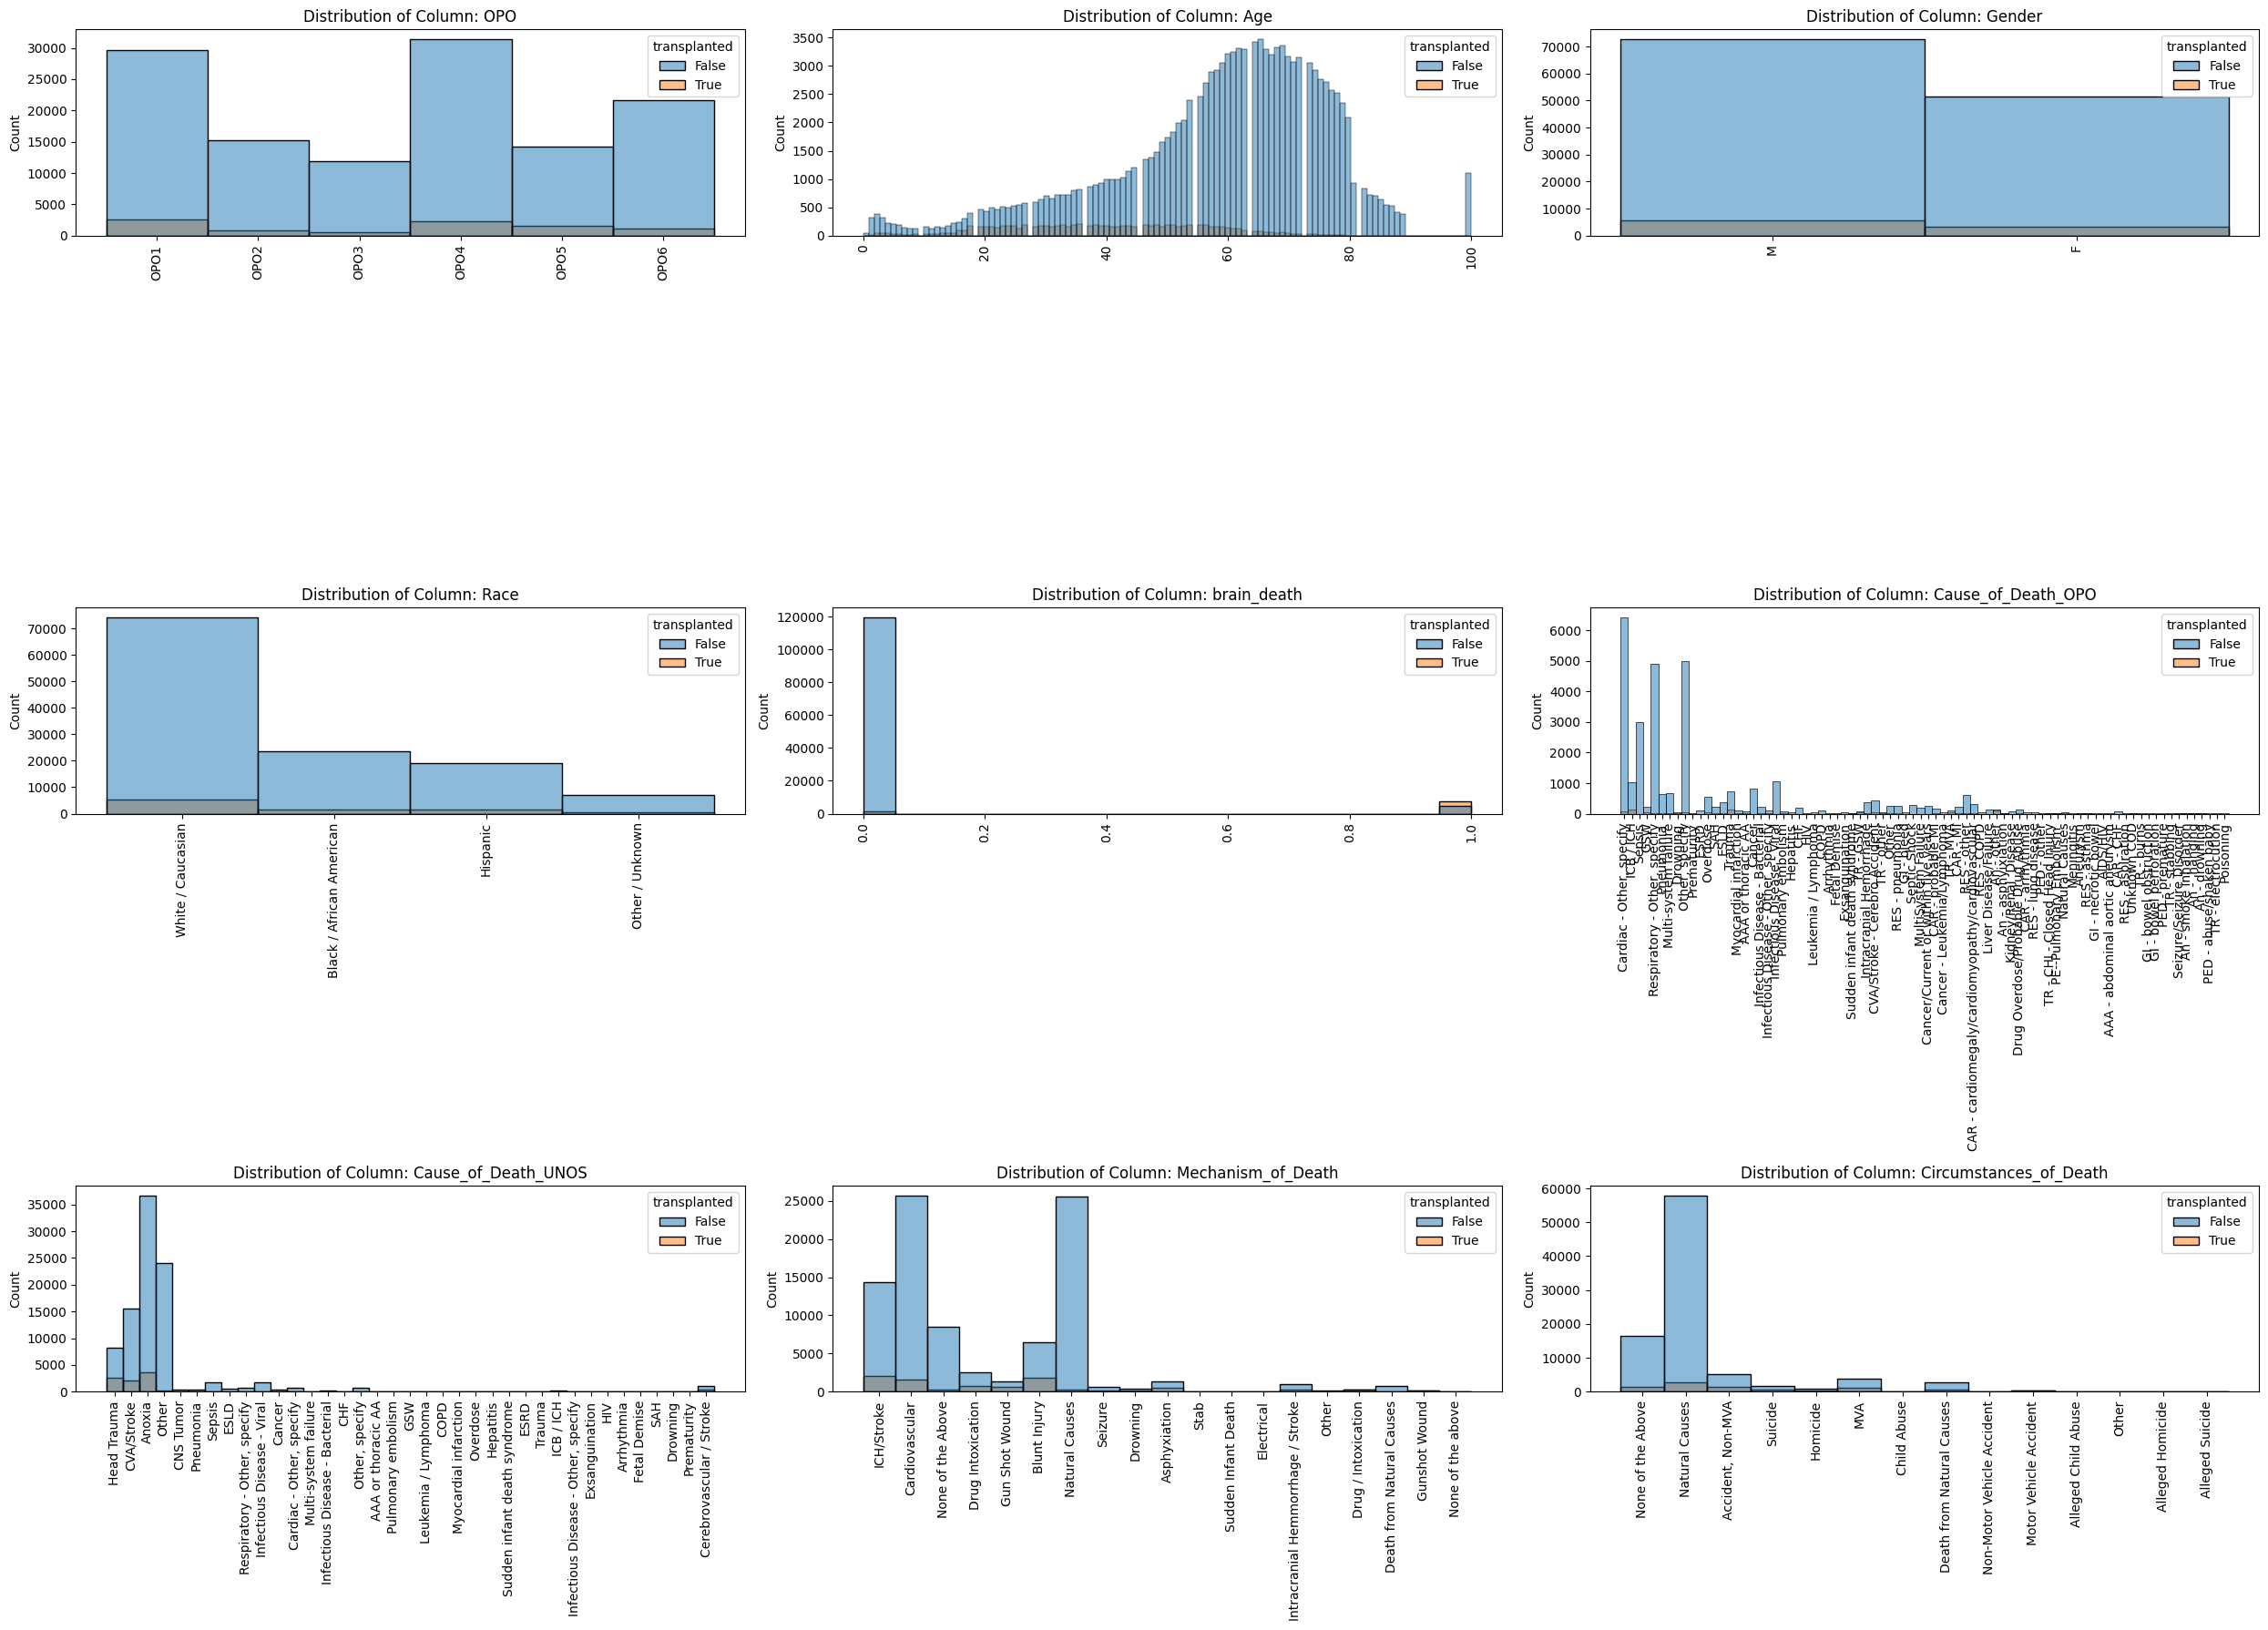

In [8]:
#Batch process as running this loop on entire dataset causes system to crash

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 18), sharex=False, sharey=False)
axes = axes.ravel()
cols = df.columns[:9]

for col, ax in zip(cols, axes):
    sns.histplot(data=df, x=col, hue='transplanted', fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

#fig.delaxes(axes[5])  # delete the empty subplot
fig.tight_layout()
plt.show()

In [ ]:
# Display unique values for OPO and UNOS definitions
 #ESLD=end-stage liver failure, CHF=congestive heart failure, GSW=gunshot wound, ESRD=end stage renal (kidney) disease, SAH=Subarachnoid hemorrhage (SAH)
print(df['Cause_of_Death_OPO'].unique())
print(df['Cause_of_Death_UNOS'].unique())
print(df['Mechanism_of_Death'].unique())
print(df['Circumstances_of_Death'].unique())

[nan 'Cardiac - Other, specify' 'ICB / ICH' 'Sepsis' 'GSW'
 'Respiratory - Other, specify' 'Pneumonia' 'Multi-system failure'
 'Drowning' 'Other, specify' 'Prematurity' 'ESRD' 'Overdose' 'SAH' 'ESLD'
 'Trauma' 'Myocardial infarction' 'AAA or thoracic AA' 'Cancer'
 'Infectious Disease - Bacterial' 'Infectious Disease - Other, specify'
 'Infectious Disease - Viral' 'Pulmonary embolism' 'Hepatitis' 'CHF' 'HIV'
 'Leukemia / Lymphoma' 'COPD' 'Arrhythmia' 'Fetal Demise' 'Exsanguination'
 'Sudden infant death syndrome' 'TR - GSW' 'Intracranial Hemorrhage'
 'CVA/Stroke - Cerebro Accident' 'TR - other' 'Other' 'RES - pneumonia'
 'GI - bleed' 'Septic Shock' 'MultiSystem Failure'
 'Cancer/Current or within five years' 'CAR - probable MI'
 'Cancer - Leukemia/Lymphoma' 'TR - MVA' 'CAR - MI' 'RES - other'
 'CAR - cardiomegaly/cardiomyopathy/cardiovascular' 'RES - COPD'
 'Liver Disease/Failure' 'An - other' 'An - asphyixiation'
 'Kidney/Renal  Disease' 'Drug Overdose/Probable Drug Abuse'
 'CAR - arrh

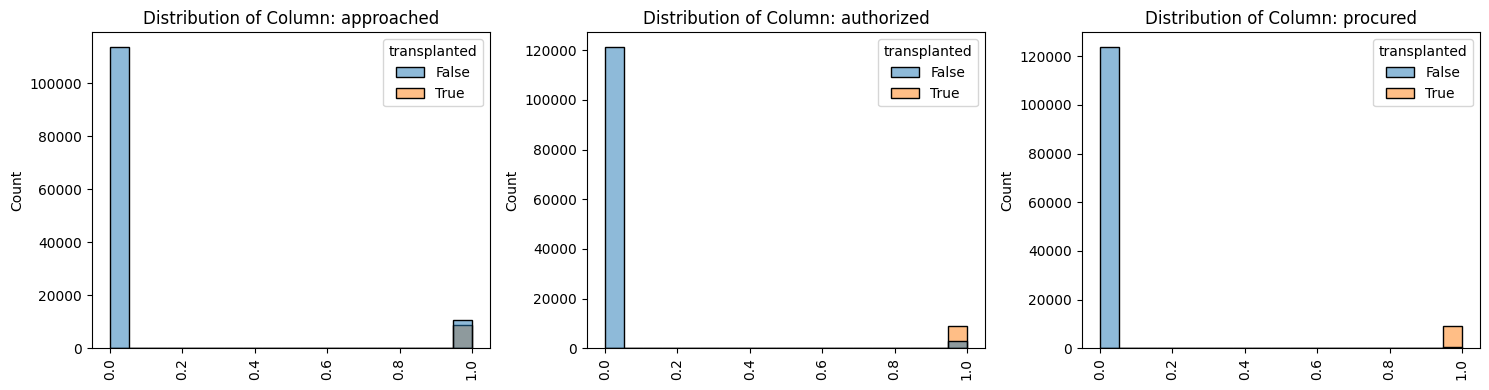

In [ ]:
#Batch process as running this loop on entire dataset causes system to crash

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)
axes = axes.ravel()
cols = df.columns[9:12]

for col, ax in zip(cols, axes):
    sns.histplot(data=df, x=col, hue='transplanted', fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

#fig.delaxes(axes[7])  # delete the empty subplot
fig.tight_layout()
plt.show()

#516 value in lung left and right columns - no interpretation available, likely data entry error

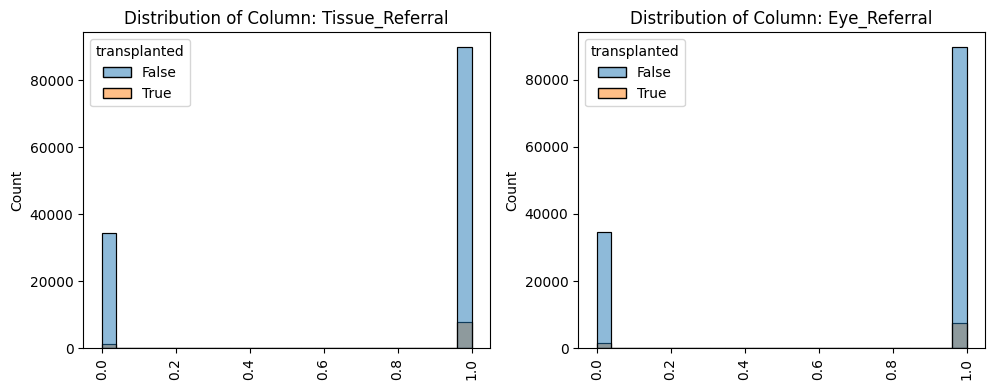

In [ ]:
#Batch process as running this loop on entire dataset causes system to crash

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)
axes = axes.ravel()
cols = df.columns[13:15]

for col, ax in zip(cols, axes):
    sns.histplot(data=df, x=col, hue='transplanted', fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

fig.delaxes(axes[2])  # delete the empty subplot
fig.tight_layout()
plt.show()

#516 value in lung left and right columns - no interpretation available, likely data entry error

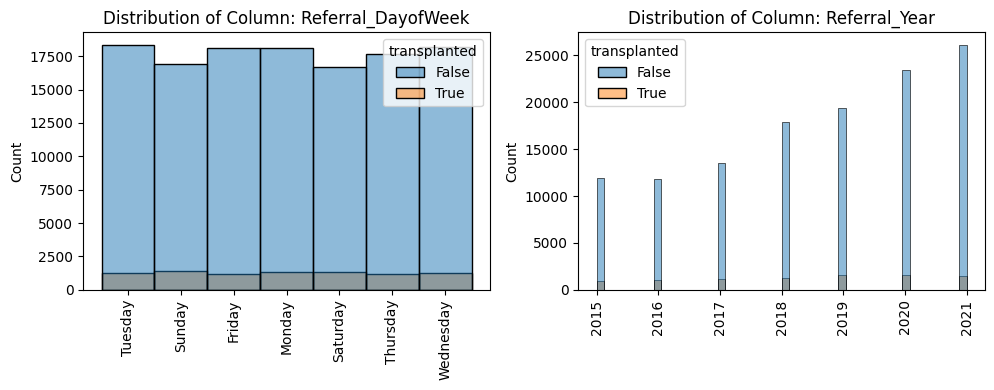

In [ ]:
#Batch process as running this loop on entire dataset causes system to crash

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)
axes = axes.ravel()
cols = df.columns[21:23]

for col, ax in zip(cols, axes):
    sns.histplot(data=df, x=col, hue='transplanted', fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

fig.delaxes(axes[2])  # delete the empty subplot
fig.tight_layout()
plt.show()

#516 value in lung left and right columns - no interpretation available, likely data entry error

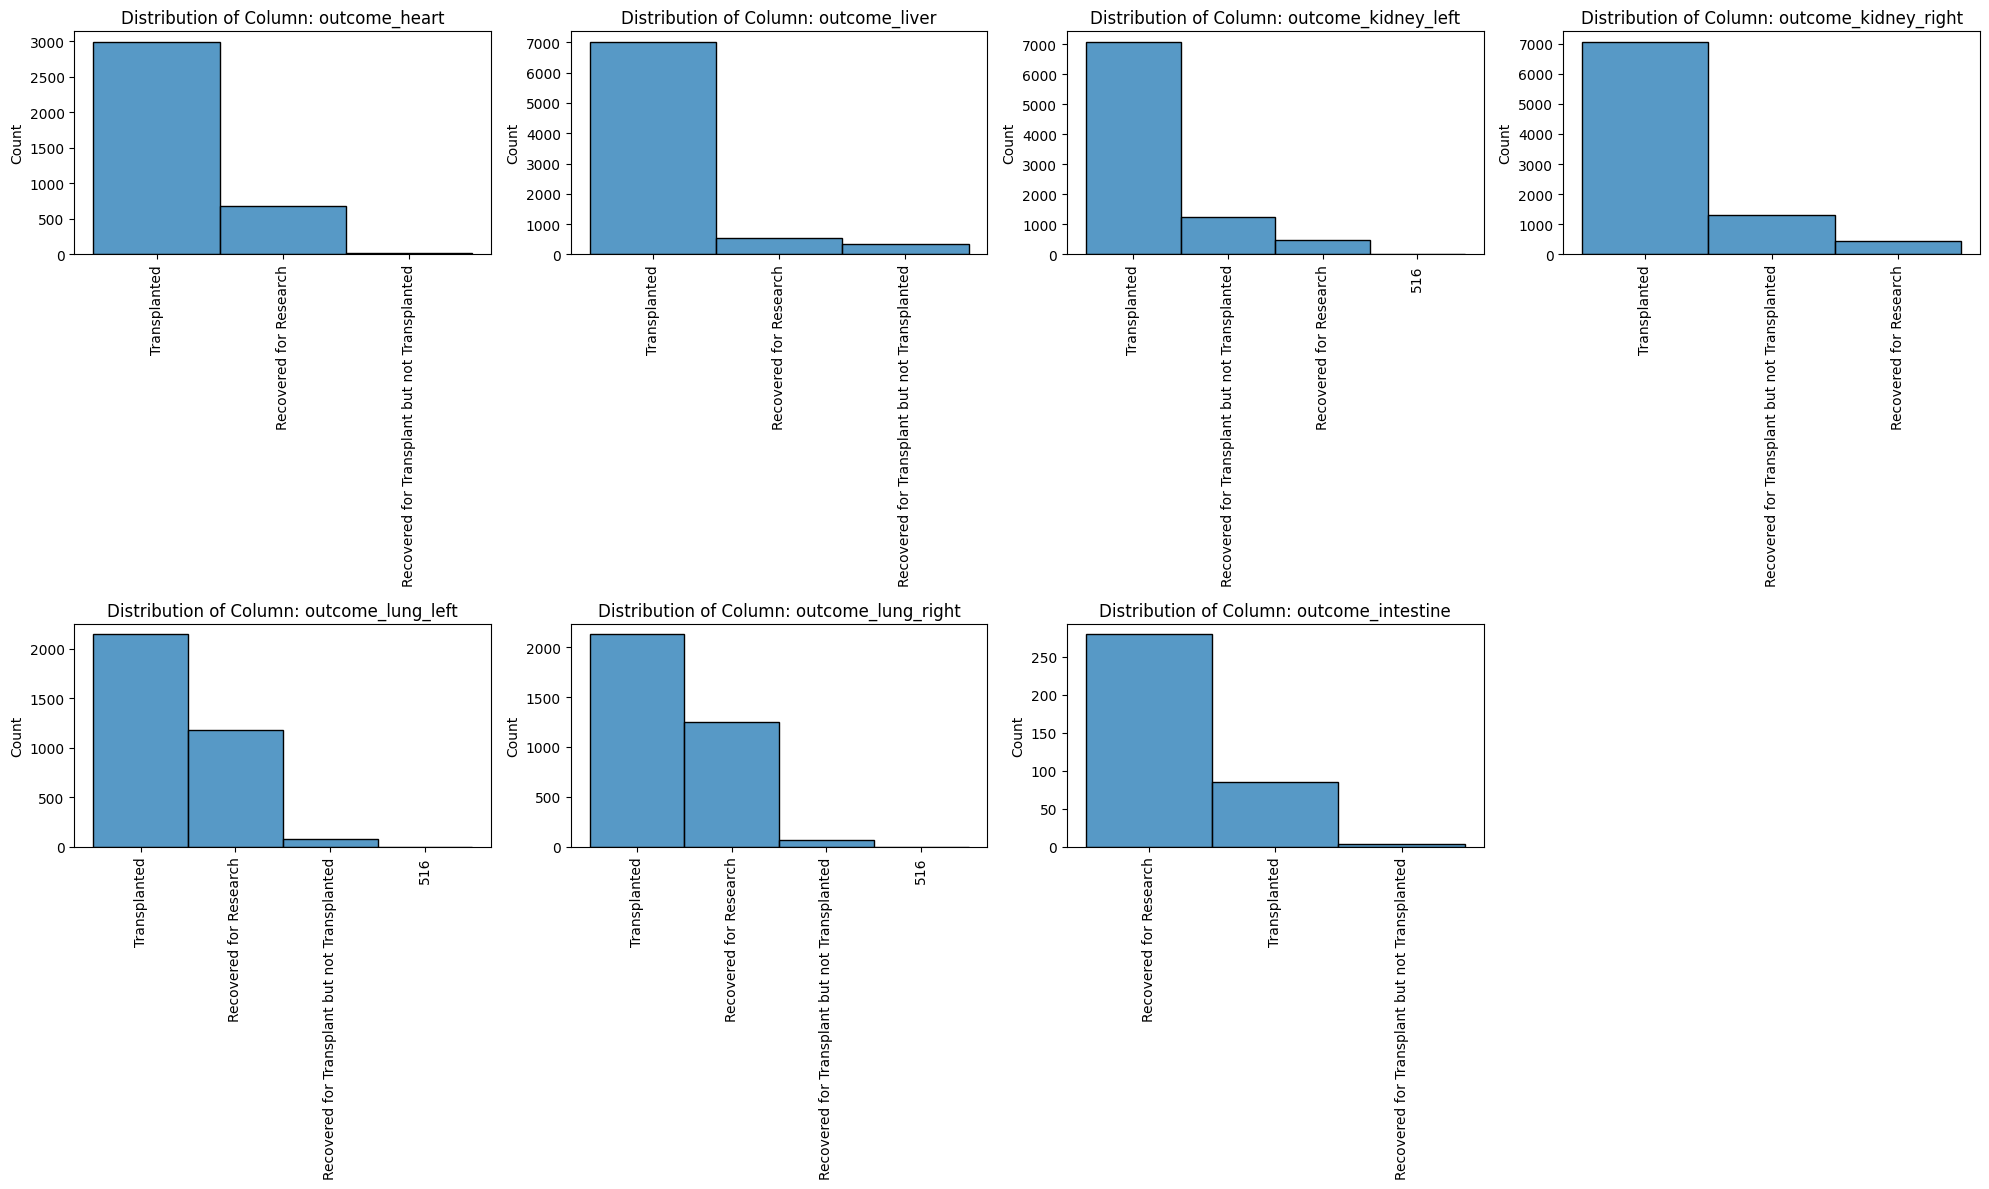

In [ ]:
#Batch process as running this loop on entire dataset causes system to crash

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12), sharex=False, sharey=False)
axes = axes.ravel()
cols = df.columns[-8:-1]

for col, ax in zip(cols, axes):
    sns.histplot(data=df, x=col, fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

fig.delaxes(axes[7])  # delete the empty subplot
fig.tight_layout()
plt.show()

#516 value in lung left and right columns - no interpretation available, likely data entry error

Check for multicollinearity

<Axes: >

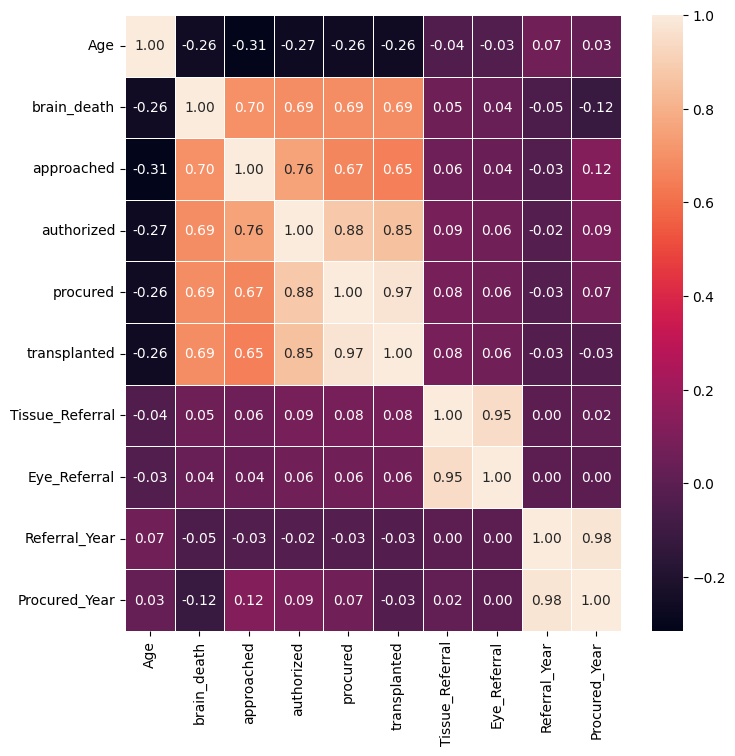

In [9]:
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f",linewidths=.5, ax=ax)

# Feature engineering
Combining categorical variables using the WHO ICD-11 Disability Assessment framework

In [4]:
#ICD classification framework to combine certain categories

def total_values(df,col,list_features,label):
  """
  Unifies similar disease categories based on International Classification of Functioning, Disability and Health (ICF)
  classification framework.

    Parameters
    ----------
    df (DataFrame): a Pandas dataframe.
    col (string): column where values are to be categorized/clustered.
    list_features (array): the values that are to be clustered as one label
    label (string): the new label for features

    Returns
    -------
    None

  """

  #Print sum of counts of categories to be clustered together
  #print(sum([(df.loc[df[col] == i]).shape[0] for i in list_features]))

  for i in list_features:
    #print(col,i)
    #Change each column value to the new label based on classification framework
    df[col].mask(df[col]==i, label, inplace=True)
    #df['Mechanism_of_Death'].mask(df['Mechanism_of_Death']=='Death from Natural Causes','Natural Causes', inplace=True)


In [11]:
#Cluster categories: cause of death

df['Cause_of_Death_UNOS'].value_counts()

Anoxia                                 40366
Other                                  24264
CVA/Stroke                             17583
Head Trauma                            10820
Infectious Disease - Viral              1822
Sepsis                                  1763
Cerebrovascular / Stroke                1353
Other, specify                           737
Cardiac - Other, specify                 701
Respiratory - Other, specify             679
ESLD                                     590
CNS Tumor                                454
Pneumonia                                416
Cancer                                   312
ICB / ICH                                201
Infectious Disease - Bacterial           155
AAA or thoracic AA                       119
Infectious Disease - Other, specify      114
CHF                                      111
Overdose                                  88
COPD                                      86
Trauma                                    84
Exsanguina

In [11]:
#Cluster categories: cause of death UNOS

df_new = df.copy()
infections=['Sepsis','Infectious Disease - Bacterial','Infectious Disease - Viral','Infectious Disease - Other, specify','Pneumonia','HIV','Hepatitis']
total_values(df_new,'Cause_of_Death_UNOS',infections,'Infectious Disease')

cardio=['CHF','AAA or thoracic AA', 'Pulmonary embolism','Myocardial infarction','Arrhythmia','Cardiac - Other, specify']
total_values(df_new,'Cause_of_Death_UNOS',cardio,'Circulatory Disease')

resp=['Anoxia','COPD','Respiratory - Other','Respiratory - Other, specify']
total_values(df_new,'Cause_of_Death_UNOS',resp,'Respiratory Disease')

newborn=['Fetal Demise','Prematurity','Sudden infant death syndrome']
total_values(df_new,'Cause_of_Death_UNOS',newborn,'Newborn Disease')

cancers=['Leukemia / Lymphoma','Cancer']
total_values(df_new,'Cause_of_Death_UNOS',cancers,'Cancer')

neuro=['CVA/Stroke','ICB / ICH', 'Cerebrovascular / Stroke', 'CNS Tumor','SAH']
total_values(df_new,'Cause_of_Death_UNOS',neuro,'Nervous Disease')

injury=['GSW','Drowning','Head Trauma','Trauma','Overdose']
total_values(df_new,'Cause_of_Death_UNOS',injury,'Injury_External Causes')

other=['Other','Other, specify']
total_values(df_new,'Cause_of_Death_UNOS',other,'Other')

In [ ]:
print(list(df_new['Cause_of_Death_UNOS'].unique()))
len(list(df_new['Cause_of_Death_UNOS'].unique())) #reduces to 13 categories

['Injury_External Causes', nan, 'Nervous Disease', 'Respiratory Disease', 'Other', 'Infectious Disease', 'ESLD', 'Cancer', 'Circulatory Disease', 'Multi-system failure', 'Newborn Disease', 'ESRD', 'Exsanguination']


13

In [ ]:
# Cluster categories: mechanism of death
df['Mechanism_of_Death'].value_counts()

Cardiovascular                       27266
Natural Causes                       25884
ICH/Stroke                           16476
None of the Above                     8755
Blunt Injury                          8313
Drug Intoxication                     3285
Gun Shot Wound                        1992
Asphyxiation                          1939
Intracranial Hemmorrhage / Stroke     1311
Death from Natural Causes              890
Seizure                                775
Drug / Intoxication                    546
Drowning                               507
Gunshot Wound                          297
Other                                  112
Stab                                    76
Electrical                              51
Sudden Infant Death                     41
None of the above                       16
Name: Mechanism_of_Death, dtype: int64

In [12]:
# Cluster categories: mechanism of death

# Taking only natural causes
natural_causes=['Natural Causes','Death from Natural Causes']
total_values(df_new,'Mechanism_of_Death',natural_causes,'Natural Causes')

# Taking only injuries and external causes: blunt injury, drug intoxication, gunshot wound, asphyxiation, drowning, stab, electrical
injury_external=['Blunt Injury','Drug Intoxication','Gun Shot Wound','Asphyxiation','Drug / Intoxication',
                 'Drowning','Gunshot Wound','Stab','Electrical']
total_values(df_new,'Mechanism_of_Death',injury_external,'Injury_External Causes')

# Taking only nervous system related disorders: stroke, seizure
nervous_diseases=['ICH/Stroke','Intracranial Hemmorrhage / Stroke','Seizure']
total_values(df_new,'Mechanism_of_Death',nervous_diseases,'Nervous System Diseases')

# None of the above
nofa=['None of the Above','None of the above']
total_values(df_new,'Mechanism_of_Death',nofa,'None of the Above')

In [14]:
print(list(df_new['Mechanism_of_Death'].unique()))
df_new['Mechanism_of_Death'].value_counts() #reduced to 7 categories

[nan, 'Nervous System Diseases', 'Cardiovascular', 'None of the Above', 'Injury_External Causes', 'Natural Causes', 'Sudden Infant Death', 'Other']


Cardiovascular             27266
Natural Causes             26774
Nervous System Diseases    18562
Injury_External Causes     17006
None of the Above           8771
Other                        112
Sudden Infant Death           41
Name: Mechanism_of_Death, dtype: int64

In [15]:
# Cluster categories: Circumstances of Death
df['Circumstances_of_Death'].value_counts()

Natural Causes                60699
None of the Above             17859
Accident, Non-MVA              6446
MVA                            5045
Death from Natural Causes      3470
Suicide                        2282
Homicide                       1293
Motor Vehicle Accident          481
Non-Motor Vehicle Accident      336
Alleged Suicide                 293
Alleged Homicide                141
Child Abuse                     127
Other                            95
Alleged Child Abuse              20
Name: Circumstances_of_Death, dtype: int64

In [13]:
# Cluster categories: Circumstances of Death

# Taking only natural causes
natural_causes=['Natural Causes','Death from Natural Causes']
total_values(df_new,'Circumstances_of_Death',natural_causes,'Natural Causes')

# Taking only motor vehicle accidents
mva=['Motor Vehicle Accident','MVA']
total_values(df_new,'Circumstances_of_Death',mva,'Motor Accident')

# Taking only non-motor vehicle accidents
non_mva=['Non-Motor Vehicle Accident','Accident, Non-MVA']
total_values(df_new,'Circumstances_of_Death',non_mva,'Non-motor Accident')

# Suicide - real or alleged
suicide=['Suicide','Alleged Suicide']
total_values(df_new,'Circumstances_of_Death',suicide,'Suicide')

# Homicide - real or alleged
homicide=['Homicide','Alleged Homicide']
total_values(df_new,'Circumstances_of_Death',homicide,'Homicide')

# Child Abuse - real or alleged
child_abuse=['Child Abuse','Alleged Child Abuse']
total_values(df_new,'Circumstances_of_Death',child_abuse,'Homicide')

In [17]:
print(list(df_new['Circumstances_of_Death'].unique()))
df_new['Circumstances_of_Death'].value_counts() #reduced to 7 categories

[nan, 'None of the Above', 'Natural Causes', 'Non-motor Accident', 'Suicide', 'Homicide', 'Motor Accident', 'Other']


Natural Causes        64169
None of the Above     17859
Non-motor Accident     6782
Motor Accident         5526
Suicide                2575
Homicide               1581
Other                    95
Name: Circumstances_of_Death, dtype: int64

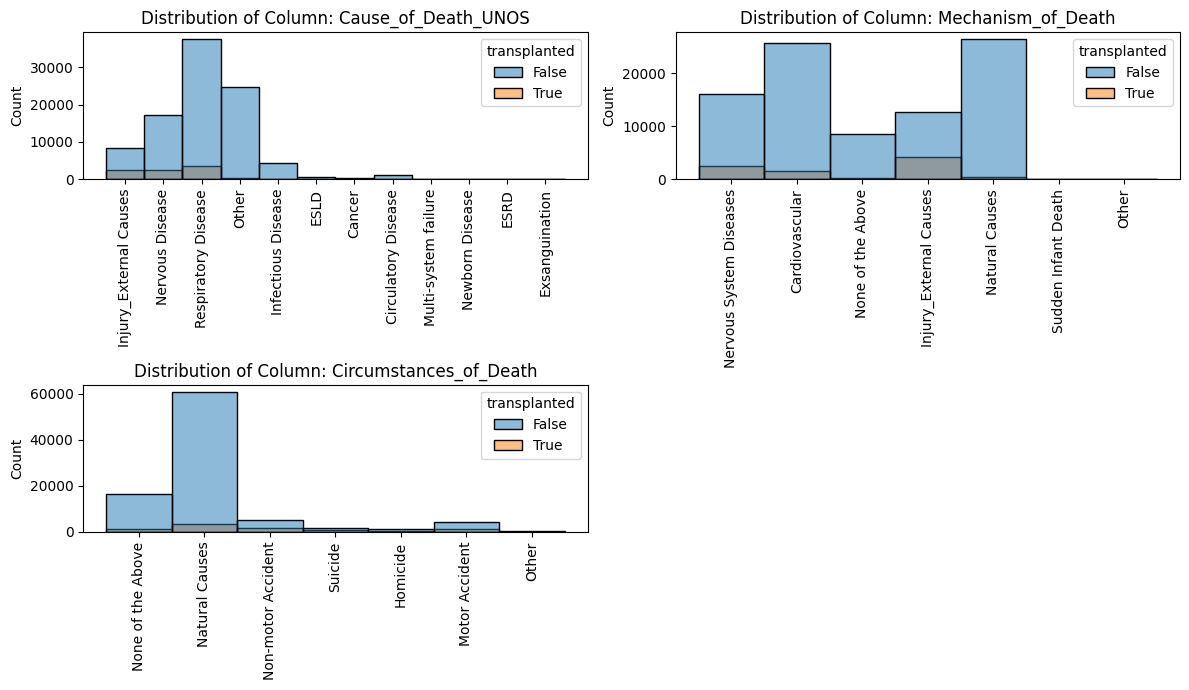

In [ ]:
#After clustering categories for 3 features: plot results

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7), sharex=False, sharey=False)
axes = axes.ravel()
cols = df_new.columns[6:9]

for col, ax in zip(cols, axes):
    sns.histplot(data=df_new, x=col, hue='transplanted', fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

fig.delaxes(axes[3])  # delete the empty subplot
fig.tight_layout()
plt.show()

In [8]:
# Store old copy for question 2 - we need the outcome organ variables
df_new2=df_new.copy()

Dropping features

In [ ]:
#Features we have now
df_new.columns

Index(['OPO', 'Age', 'Gender', 'Race', 'brain_death', 'Cause_of_Death_OPO',
       'Cause_of_Death_UNOS', 'Mechanism_of_Death', 'Circumstances_of_Death',
       'approached', 'authorized', 'procured', 'transplanted',
       'Tissue_Referral', 'Eye_Referral', 'time_asystole', 'time_brain_death',
       'time_referred', 'time_approached', 'time_authorized', 'time_procured',
       'Referral_DayofWeek', 'Referral_Year', 'Procured_Year', 'outcome_heart',
       'outcome_liver', 'outcome_kidney_left', 'outcome_kidney_right',
       'outcome_lung_left', 'outcome_lung_right', 'outcome_intestine',
       'outcome_pancreas'],
      dtype='object')

In [14]:
# Drop variables since they are all either random/inaccurate, largely missing, and the organ outcomes are for Part 2
df_new = df_new.drop(['time_asystole', 'time_brain_death', 'Cause_of_Death_OPO', 'Procured_Year',
                      'time_referred', 'time_approached', 'time_authorized', 'time_procured',
                      'outcome_heart', 'outcome_liver',
                      'outcome_kidney_left', 'outcome_kidney_right',
                      'outcome_lung_left', 'outcome_lung_right',
                      'outcome_intestine', 'outcome_pancreas'], axis=1)

In [15]:
#Move transplanted column to end
df_new.insert(len(df_new.columns)-1, 'transplanted', df_new.pop('transplanted'))

df_new.columns

Index(['OPO', 'Age', 'Gender', 'Race', 'brain_death', 'Cause_of_Death_UNOS',
       'Mechanism_of_Death', 'Circumstances_of_Death', 'approached',
       'authorized', 'procured', 'Tissue_Referral', 'Eye_Referral',
       'Referral_DayofWeek', 'Referral_Year', 'transplanted'],
      dtype='object')

# Build and test models to predict transplant event

In [17]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    """
    Unifies similar disease categories based on International Classification of Functioning, Disability and Health (ICF)
    classification framework.

      Parameters
      ----------
      Y_pred (array): list of predictive values.
      Y (array): list of ground truth values.

      Returns
      -------
      conf_matrix (Matrix): confusion matrix for model predictions vs actual.
      class_report (string): class report for model predictions vs actual.
      auc (float): AUC value of model.

    """
    # Calculate confusion matrix, classification report, ROC AUC
    conf_matrix = confusion_matrix(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, class_report, auc

# Define a function to print the computed scores
def print_scores(conf_matrix, class_report, auc):
    """
    Prints scores.

      Parameters
      ----------
      conf_matrix (Matrix): confusion matrix for model predictions vs actual.
      class_report (string): class report for model predictions vs actual.
      auc (float): AUC value of model.

      Returns
      -------
      None

    """
    print('AUC : ', auc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

One-Hot encoding

In [18]:
ohe = OneHotEncoder(categories='auto',sparse=False)
df_new['OPO'] = ohe.fit_transform(df_new['OPO'].values.reshape(-1,1))
df_new['Gender'] = ohe.fit_transform(df_new['Gender'].values.reshape(-1,1))
df_new['Race'] = ohe.fit_transform(df_new['Race'].values.reshape(-1,1))
df_new['brain_death'] = ohe.fit_transform(df_new['brain_death'].values.reshape(-1,1))
#df_new['Cause_of_Death_OPO'] = ohe.fit_transform(df_new['Cause_of_Death_OPO'].values.reshape(-1,1))
df_new['Cause_of_Death_UNOS'] = ohe.fit_transform(df_new['Cause_of_Death_UNOS'].values.reshape(-1,1))
df_new['Mechanism_of_Death'] = ohe.fit_transform(df_new['Mechanism_of_Death'].values.reshape(-1,1))
df_new['Circumstances_of_Death'] = ohe.fit_transform(df_new['Circumstances_of_Death'].values.reshape(-1,1))
df_new['Referral_DayofWeek'] = ohe.fit_transform(df_new['Referral_DayofWeek'].values.reshape(-1,1))
df_new['Referral_Year'] = ohe.fit_transform(df_new['Referral_Year'].values.reshape(-1,1))
#df_new['Procured_Year'] = ohe.fit_transform(df_new['Procured_Year'].values.reshape(-1,1))
df_new['approached'] = ohe.fit_transform(df_new['approached'].values.reshape(-1,1))
df_new['authorized'] = ohe.fit_transform(df_new['authorized'].values.reshape(-1,1))
df_new['procured'] = ohe.fit_transform(df_new['procured'].values.reshape(-1,1))
df_new['transplanted'] = ohe.fit_transform(df_new['transplanted'].values.reshape(-1,1))

# CV stage - Part 1

Defining CV functions

In [20]:
# Define a function to run k-fold cross-validation

def run_kfold_regression(X, y, k, model, model_complexity, sample=True):
  """
  Run K-fold CV.

  Parameters
  ----------
  X (array):
  y (array):
  k (int): number of folds.
  model (Model): machine learning model.
  model_complexity (int): degree of complexity.
  sample (Boolean): determine whether to apply undersampling or not.

  Returns
  -------
  mean_train_loss (float): Mean loss for train set.
  mean_validation_loss (float): Mean loss for validation set.
  mean_auc_train (float): Mean AUC value for training set.
  mean_auc_val (float): Mean AUC value for validation set.

  """
  mean_train_loss = 0
  mean_validation_loss = 0
  mean_auc_train = 0
  mean_auc_val = 0

  count=1

  kfold=StratifiedKFold(n_splits=k, shuffle=True)

  for train_indexes, val_indexes in kfold.split(X,y):

    # Split train sets from the data using train and validation indexes
    k_fold_train_x = X[train_indexes]
    k_fold_train_y = y[train_indexes]
    val_x = X[val_indexes]
    val_y = y[val_indexes]

    #Tomek Links remove close opposing majority class instances to enhance class separation in classification.
    tl = TomekLinks()

    # Preprocess and transform input data for TRAIN set
    imputer = IterativeImputer(max_iter=10, random_state=0)
    k_fold_train_x = imputer.fit_transform(k_fold_train_x) #(df_new.drop('transplanted', axis=1).to_numpy())

    # Stacking polynomials here since imputation takes extremely long if applied to full stacked version
    k_fold_train_x = np.hstack([k_fold_train_x**i for i in range(1, model_complexity+1)])

    st_x = StandardScaler()
    k_fold_train_x = st_x.fit_transform(k_fold_train_x)

    # For unbalanced training set
    if sample==True:
      k_fold_train_x, k_fold_train_y = tl.fit_resample(k_fold_train_x, k_fold_train_y)

    # Preprocess and transform input data for VALIDATION set
    val_x = imputer.fit_transform(val_x) #(df_new.drop('transplanted', axis=1).to_numpy())

    # Stacking polynomials here since imputation takes extremely long if applied to full stacked version
    val_x = np.hstack([val_x**i for i in range(1, model_complexity+1)])

    val_x = st_x.transform(val_x)

    # For unbalanced validation set
    if sample==True:
      val_x, val_y = tl.fit_resample(val_x, val_y)

    # Build model
    model.fit(k_fold_train_x, k_fold_train_y)

    # Get training
    train_y_pred = model.predict(k_fold_train_x)
    try:
      conf_matrix_train, class_report_train, auc_train=get_scores(train_y_pred, k_fold_train_y)
      print_scores(conf_matrix_train, class_report_train, auc_train)
      train_mse = mean_squared_error(k_fold_train_y, train_y_pred)
      mean_train_loss += train_mse
      mean_auc_train += auc_train

   # I no longer get this error - but keeping an except line just in case (happens for non-stratified KFold)
    except ValueError:
      print('Only one class found')
      auc_train=0
      mean_auc_train += auc_train

    # Get validation
    val_y_pred = model.predict(val_x)
    try:
      conf_matrix_val, class_report_val, auc_val=get_scores(val_y_pred, val_y)
      print_scores(conf_matrix_val, class_report_val, auc_val)
      validation_mse = mean_squared_error(val_y, val_y_pred)
      mean_validation_loss += validation_mse
      mean_auc_val += auc_val

   # I no longer get this error - but keeping an except line just in case (happens for non-stratified KFold)
    except ValueError:
      print('Only one class found')
      auc_val=0
      mean_auc_val += auc_val
      pass

    print(f"Fold:{count}")
    count+=1

  mean_train_loss /= k
  mean_validation_loss /= k
  mean_auc_train /= k
  mean_auc_val /= k

  return mean_train_loss, mean_validation_loss, mean_auc_train, mean_auc_val


Split training and test data for CV

In [21]:
X=df_new.drop('transplanted', axis=1).to_numpy()
y=df_new['transplanted'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

K-Nearest Neighbors

In [ ]:
# Loop over different model complexities

# get the start time
st = time.time()

model_complexity_list_knn = []
train_loss_list_knn = []
validation_loss_list_knn = []
auc_train_list_knn = []
auc_val_list_knn = []

a=0.07 #reflect actual class imbalance in dataset

count=1

for model_complexity in range(1, 11):
  print(f"Complexity {count} started")

  #X_k = np.hstack([X_train**i for i in range(1, model_complexity+1)])
  X_k = X_train
  y_k = y_train

  # Run k-fold cross-validation and compute train and validation losses
  model = KNeighborsClassifier()

  train_loss, validation_loss, auc_train, auc_val = run_kfold_regression(X_k, y_k, 5, model, model_complexity, sample=True)

  model_complexity_list_knn.append(model_complexity)
  train_loss_list_knn.append(train_loss)
  validation_loss_list_knn.append(validation_loss)
  auc_train_list_knn.append(auc_train)
  auc_val_list_knn.append(auc_val)

  print(f"Complexity {count} finished")
  count+=1

et = time.time()
# get the execution time
print('Execution time:', et - st, 'seconds')



2023-10-28 20:45:07.904622
Complexity 1 started
AUC :  0.9782793781123003
Confusion Matrix:
[[ 5013   226]
 [   21 69231]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      5239
         1.0       1.00      1.00      1.00     69252

    accuracy                           1.00     74491
   macro avg       1.00      0.98      0.99     74491
weighted avg       1.00      1.00      1.00     74491

AUC :  0.9844785623866307
Confusion Matrix:
[[ 1246    39]
 [   12 17312]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1285
         1.0       1.00      1.00      1.00     17324

    accuracy                           1.00     18609
   macro avg       0.99      0.98      0.99     18609
weighted avg       1.00      1.00      1.00     18609

Fold:1
AUC :  0.9785976157588224
Confusion Matrix:
[[ 5025   224]
 [    9 69236]]

Classification Re

<Axes: xlabel='complexity', ylabel='loss'>

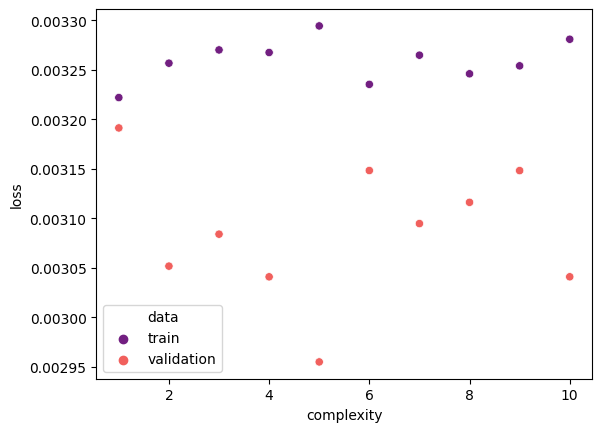

In [ ]:
validation_data_knn = {'complexity': model_complexity_list_knn + model_complexity_list_knn,
                   'loss': train_loss_list_knn + validation_loss_list_knn,
                   'mean_auc': auc_train_list_knn + auc_val_list_knn,
                   'data': ['train']*len(train_loss_list_knn) + ['validation']*len(train_loss_list_knn)
                   }

# Create a DataFrame from the validation data
validation_df_knn = pd.DataFrame(validation_data_knn)

# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_knn, x='complexity', y='loss', hue='data', palette='magma')

<Axes: xlabel='complexity', ylabel='mean_auc'>

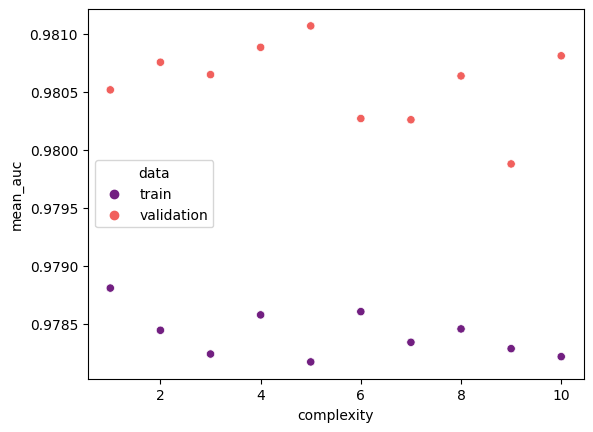

In [ ]:
sns.scatterplot(data=validation_df_knn, x='complexity', y='mean_auc', hue='data', palette='magma')

In [ ]:
validation_df_knn[validation_df_knn['data']=='train']

,complexity,loss,mean_auc,data
0,1,0.003222,0.978806,train
1,2,0.003257,0.978442,train
2,3,0.003270,0.978237,train
3,4,0.003267,0.978575,train
4,5,0.003294,0.978169,train
5,6,0.003235,0.978603,train
6,7,0.003265,0.978338,train
7,8,0.003246,0.978454,train
8,9,0.003254,0.978283,train
9,10,0.003281,0.978214,train


In [ ]:
validation_df_knn[validation_df_knn['data']=='validation']

,complexity,loss,mean_auc,data
10,1,0.003191,0.980518,validation
11,2,0.003052,0.980757,validation
12,3,0.003084,0.980650,validation
13,4,0.003041,0.980885,validation
14,5,0.002955,0.981070,validation
15,6,0.003148,0.980271,validation
16,7,0.003095,0.980260,validation
17,8,0.003116,0.980638,validation
18,9,0.003148,0.979878,validation
19,10,0.003041,0.980812,validation


In [ ]:
# KNN for no oversampled data

# get the start time
st = time.time()

model_complexity_list_knn_nos = []
train_loss_list_knn_nos = []
validation_loss_list_knn_nos = []
auc_train_list_knn_nos = []
auc_val_list_knn_nos = []

count=1

for model_complexity in range(1, 11):
  print(f"Complexity {count} started")

  #X_k = np.hstack([X_train**i for i in range(1, model_complexity+1)])
  X_k = X_train
  y_k = y_train

  # Run k-fold cross-validation and compute train and validation losses
  model = KNeighborsClassifier()

  train_loss, validation_loss, auc_train, auc_val = run_kfold_regression(X_k, y_k, 5, model, model_complexity, sample=False)

  model_complexity_list_knn_nos.append(model_complexity)
  train_loss_list_knn_nos.append(train_loss)
  validation_loss_list_knn_nos.append(validation_loss)
  auc_train_list_knn_nos.append(auc_train)
  auc_val_list_knn_nos.append(auc_val)

  print(f"Complexity {count} finished")
  count+=1

et = time.time()
# get the execution time
print('Execution time:', et - st, 'seconds')




2023-10-30 15:08:30.258239
Complexity 1 started
AUC :  0.9766529153476726
Confusion Matrix:
[[ 5014   244]
 [   20 69258]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      5258
         1.0       1.00      1.00      1.00     69278

    accuracy                           1.00     74536
   macro avg       1.00      0.98      0.99     74536
weighted avg       1.00      1.00      1.00     74536

AUC :  0.9676360970503919
Confusion Matrix:
[[ 1251    86]
 [    7 17290]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96      1337
         1.0       1.00      1.00      1.00     17297

    accuracy                           1.00     18634
   macro avg       0.99      0.97      0.98     18634
weighted avg       1.00      1.00      0.99     18634

Fold:1
AUC :  0.9747202364780325
Confusion Matrix:
[[ 5011   265]
 [   23 69237]]

Classification Re

<Axes: xlabel='complexity', ylabel='loss'>

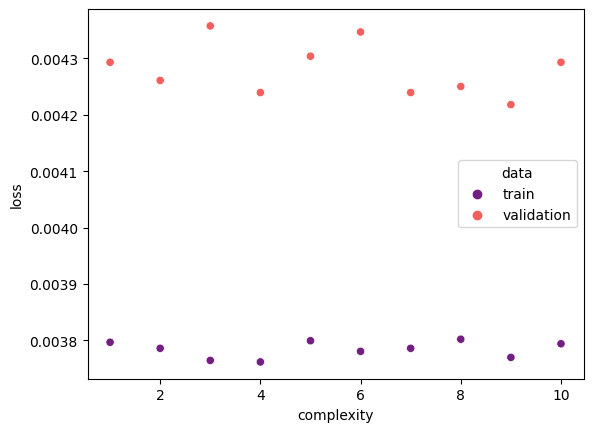

In [ ]:
validation_data_knn_nos = {'complexity': model_complexity_list_knn_nos + model_complexity_list_knn_nos,
                   'loss': train_loss_list_knn_nos + validation_loss_list_knn_nos,
                   'mean_auc': auc_train_list_knn_nos + auc_val_list_knn_nos,
                   'data': ['train']*len(train_loss_list_knn_nos) + ['validation']*len(train_loss_list_knn_nos)
                   }

# Create a DataFrame from the validation data
validation_df_knn_nos = pd.DataFrame(validation_data_knn_nos)

# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_knn_nos, x='complexity', y='loss', hue='data', palette='magma')


In [ ]:
validation_df_knn_nos[validation_df_knn_nos['data']=='train']

,complexity,loss,mean_auc,data
0,1,0.003797,0.975358,train
1,2,0.003786,0.975026,train
2,3,0.003765,0.975104,train
3,4,0.003762,0.975106,train
4,5,0.003800,0.975074,train
5,6,0.003781,0.975183,train
6,7,0.003786,0.975243,train
7,8,0.003802,0.974932,train
8,9,0.003770,0.975241,train
9,10,0.003794,0.974892,train


In [ ]:
validation_df_knn_nos[validation_df_knn_nos['data']=='validation']

,complexity,loss,mean_auc,data
10,1,0.004293,0.973135,validation
11,2,0.004261,0.973140,validation
12,3,0.004358,0.972623,validation
13,4,0.004240,0.972966,validation
14,5,0.004304,0.973074,validation
15,6,0.004347,0.973133,validation
16,7,0.004240,0.973179,validation
17,8,0.004250,0.972959,validation
18,9,0.004218,0.973440,validation
19,10,0.004293,0.972927,validation


Logistic regression

In [ ]:
# Loop over different model complexities

# get the start time
st = time.time()

model_complexity_list_lr = []
train_loss_list_lr = []
validation_loss_list_lr = []
auc_train_list_lr = []
auc_val_list_lr = []

a=0.07 #reflect actual class imbalance in dataset

count=1

for model_complexity in range(1, 11):
  print(f"Complexity {count} started")

  #X_k = np.hstack([X_train**i for i in range(1, model_complexity+1)])
  X_k = X_train
  y_k = y_train

  # Run k-fold cross-validation and compute train and validation losses
  model = LogisticRegression(class_weight={0: 1-a, 1: a},penalty='l2',solver='lbfgs') #{0: a, 1: 1-a} when a=0.3

  train_loss, validation_loss, auc_train, auc_val = run_kfold_regression(X_k, y_k, 5, model, model_complexity, sample=True)

  model_complexity_list_lr.append(model_complexity)
  train_loss_list_lr.append(train_loss)
  validation_loss_list_lr.append(validation_loss)
  auc_train_list_lr.append(auc_train)
  auc_val_list_lr.append(auc_val)

  print(f"Complexity {count} finished")
  count+=1

et = time.time()
# get the execution time
print('Execution time:', et - st, 'seconds')


2023-10-28 18:04:31.508659
Complexity 1 started
AUC :  0.9775976355741394
Confusion Matrix:
[[ 5033   236]
 [    1 69222]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      5269
         1.0       1.00      1.00      1.00     69223

    accuracy                           1.00     74492
   macro avg       1.00      0.98      0.99     74492
weighted avg       1.00      1.00      1.00     74492

AUC :  0.9779635258358663
Confusion Matrix:
[[ 1258    58]
 [    0 17290]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      1316
         1.0       1.00      1.00      1.00     17290

    accuracy                           1.00     18606
   macro avg       1.00      0.98      0.99     18606
weighted avg       1.00      1.00      1.00     18606

Fold:1
AUC :  0.9779604881638918
Confusion Matrix:
[[ 5033   232]
 [    1 69221]]

Classification Re

<Axes: xlabel='complexity', ylabel='loss'>

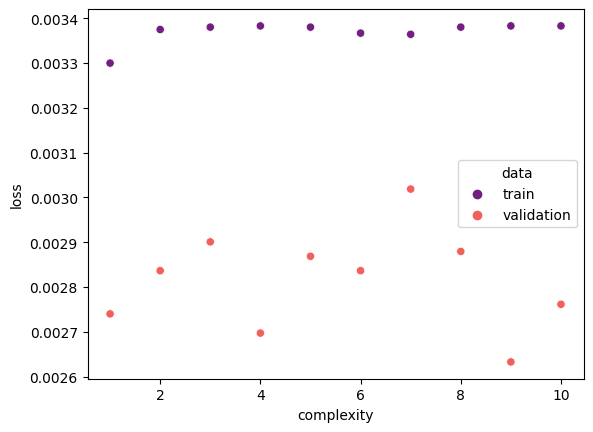

In [ ]:
validation_data_lr = {'complexity': model_complexity_list_lr + model_complexity_list_lr,
                      'loss': train_loss_list_lr + validation_loss_list_lr,
                      'mean_auc': auc_train_list_lr + auc_val_list_lr,
                      'data': ['train']*len(train_loss_list_lr) + ['validation']*len(train_loss_list_lr),
                      }

# Create a DataFrame from the validation data
validation_df_lr = pd.DataFrame(validation_data_lr)

# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_lr, x='complexity', y='loss', hue='data', palette='magma')

<Axes: xlabel='complexity', ylabel='mean_auc'>

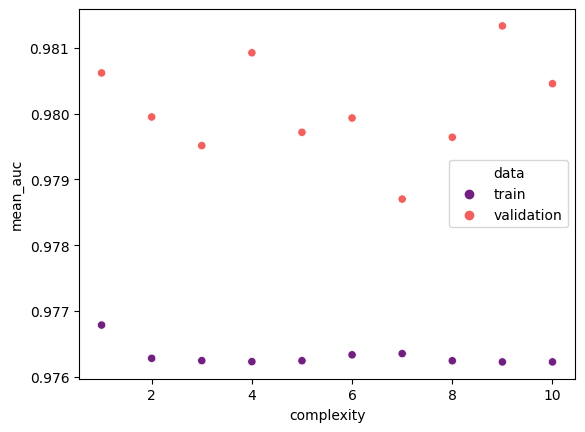

In [ ]:
# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_lr, x='complexity', y='mean_auc', hue='data', palette='magma')

In [ ]:
validation_df_lr[validation_df_lr['data']=='train']

,complexity,loss,mean_auc,data
0,1,0.003300,0.976785,train
1,2,0.003375,0.976280,train
2,3,0.003380,0.976245,train
3,4,0.003383,0.976229,train
4,5,0.003380,0.976243,train
5,6,0.003367,0.976333,train
6,7,0.003364,0.976351,train
7,8,0.003380,0.976243,train
8,9,0.003383,0.976225,train
9,10,0.003383,0.976225,train


In [ ]:
validation_df_lr[validation_df_lr['data']=='validation']

,complexity,loss,mean_auc,data
10,1,0.002740,0.980617,validation
11,2,0.002837,0.979947,validation
12,3,0.002901,0.979512,validation
13,4,0.002697,0.980923,validation
14,5,0.002869,0.979715,validation
15,6,0.002837,0.979932,validation
16,7,0.003019,0.978700,validation
17,8,0.002880,0.979639,validation
18,9,0.002633,0.981332,validation
19,10,0.002762,0.980453,validation


In [ ]:
# LR for no oversampled data

# get the start time
st = time.time()

model_complexity_list_lr_nos = []
train_loss_list_lr_nos = []
validation_loss_list_lr_nos = []
auc_train_list_lr_nos = []
auc_val_list_lr_nos = []

a=0.07 #reflect actual class imbalance in dataset

count=1

for model_complexity in range(1, 11):
  print(f"Complexity {count} started")

  #X_k = np.hstack([X_train**i for i in range(1, model_complexity+1)])
  X_k = X_train
  y_k = y_train

  # Run k-fold cross-validation and compute train and validation losses
  model = LogisticRegression(class_weight={0: 1-a, 1: a},penalty='l2') #{0: a, 1: 1-a} when a=0.3

  train_loss, validation_loss, auc_train, auc_val = run_kfold_regression(X_k, y_k, 5, model, model_complexity, sample=False)

  model_complexity_list_lr_nos.append(model_complexity)
  train_loss_list_lr_nos.append(train_loss)
  validation_loss_list_lr_nos.append(validation_loss)
  auc_train_list_lr_nos.append(auc_train)
  auc_val_list_lr_nos.append(auc_val)

  print(f"Complexity {count} finished")
  count+=1

et = time.time()
# get the execution time
print('Execution time:', et - st, 'seconds')




2023-10-30 16:12:54.648964
Complexity 1 started
AUC :  0.9735531833363135
Confusion Matrix:
[[ 5033   281]
 [    1 69221]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      5314
         1.0       1.00      1.00      1.00     69222

    accuracy                           1.00     74536
   macro avg       1.00      0.97      0.99     74536
weighted avg       1.00      1.00      1.00     74536

AUC :  0.9683544303797469
Confusion Matrix:
[[ 1258    85]
 [    0 17291]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      1343
         1.0       1.00      1.00      1.00     17291

    accuracy                           1.00     18634
   macro avg       1.00      0.97      0.98     18634
weighted avg       1.00      1.00      1.00     18634

Fold:1
AUC :  0.9721316119658855
Confusion Matrix:
[[ 5033   297]
 [    1 69205]]

Classification Re

<Axes: xlabel='complexity', ylabel='loss'>

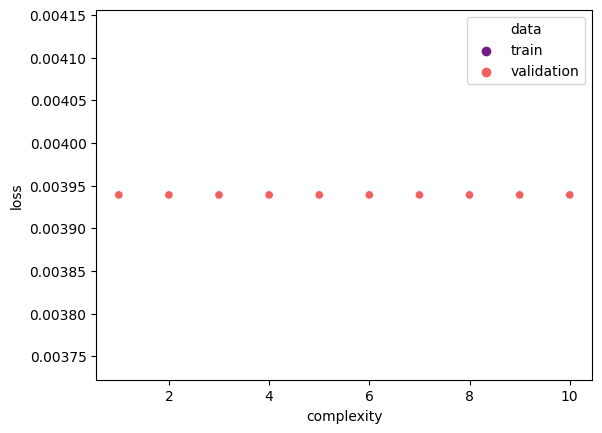

In [ ]:
validation_data_lr_nos = {'complexity': model_complexity_list_lr_nos + model_complexity_list_lr_nos,
                      'loss': train_loss_list_lr_nos + validation_loss_list_lr_nos,
                      'mean_auc': auc_train_list_lr_nos + auc_val_list_lr_nos,
                      'data': ['train']*len(train_loss_list_lr_nos) + ['validation']*len(train_loss_list_lr_nos),
                      }

# Create a DataFrame from the validation data
validation_df_lr_nos = pd.DataFrame(validation_data_lr_nos)

# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_lr_nos, x='complexity', y='loss', hue='data', palette='magma')


In [ ]:
validation_df_lr_nos[validation_df_lr_nos['data']=='train']

,complexity,loss,mean_auc,data
0,1,0.003939,0.972505,train
1,2,0.003939,0.972506,train
2,3,0.003939,0.972505,train
3,4,0.003939,0.972506,train
4,5,0.003939,0.972506,train
5,6,0.003939,0.972506,train
6,7,0.003939,0.972506,train
7,8,0.003939,0.972505,train
8,9,0.003939,0.972505,train
9,10,0.003939,0.972505,train


In [ ]:
validation_df_lr_nos[validation_df_lr_nos['data']=='validation']

,complexity,loss,mean_auc,data
10,1,0.003939,0.972518,validation
11,2,0.003939,0.972528,validation
12,3,0.003939,0.972509,validation
13,4,0.003939,0.972539,validation
14,5,0.003939,0.972523,validation
15,6,0.003939,0.972530,validation
16,7,0.003939,0.972525,validation
17,8,0.003939,0.972511,validation
18,9,0.003939,0.972516,validation
19,10,0.003939,0.972518,validation


In [ ]:
# LR with no modified class weight data (unbalanced)

# get the start time
st = time.time()

model_complexity_list_lr_unb = []
train_loss_list_lr_unb = []
validation_loss_list_lr_unb = []
auc_train_list_lr_unb = []
auc_val_list_lr_unb = []
count=1

for model_complexity in range(1, 11):
  print(f"Complexity {count} started")

  #X_k = np.hstack([X_train**i for i in range(1, model_complexity+1)])
  X_k = X_train
  y_k = y_train

  # Run k-fold cross-validation and compute train and validation losses
  model = LogisticRegression(penalty='l2')

  train_loss, validation_loss, auc_train, auc_val = run_kfold_regression(X_k, y_k, 5, model, model_complexity, sample=True)

  model_complexity_list_lr_unb.append(model_complexity)
  train_loss_list_lr_unb.append(train_loss)
  validation_loss_list_lr_unb.append(validation_loss)
  auc_train_list_lr_unb.append(auc_train)
  auc_val_list_lr_unb.append(auc_val)

  print(f"Complexity {count} finished")
  count+=1

et = time.time()
# get the execution time
print('Execution time:', et - st, 'seconds')



2023-10-30 13:31:22.082757
Complexity 1 started
AUC :  0.9772468714448236
Confusion Matrix:
[[ 5034   240]
 [    0 69218]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98      5274
         1.0       1.00      1.00      1.00     69218

    accuracy                           1.00     74492
   macro avg       1.00      0.98      0.99     74492
weighted avg       1.00      1.00      1.00     74492

AUC :  0.9761074535467422
Confusion Matrix:
[[ 1257    63]
 [    1 17294]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98      1320
         1.0       1.00      1.00      1.00     17295

    accuracy                           1.00     18615
   macro avg       1.00      0.98      0.99     18615
weighted avg       1.00      1.00      1.00     18615

Fold:1
AUC :  0.9755218750955746
Confusion Matrix:
[[ 5033   259]
 [    1 69199]]

Classification Re

In [ ]:
validation_data_lr_unb = {'complexity': model_complexity_list_lr_unb + model_complexity_list_lr_unb,
                      'loss': train_loss_list_lr_unb + validation_loss_list_lr_unb,
                      'mean_auc': auc_train_list_lr_unb + auc_val_list_lr_unb,
                      'data': ['train']*len(train_loss_list_lr_unb) + ['validation']*len(train_loss_list_lr_unb),
                      }

# Create a DataFrame from the validation data
validation_df_lr_unb = pd.DataFrame(validation_data_lr_unb)


In [ ]:
validation_df_lr_unb[validation_df_lr_unb['data']=='train']

,complexity,loss,mean_auc,data
0,1,0.003343,0.976497,train
1,2,0.003391,0.976187,train
2,3,0.003394,0.976152,train
3,4,0.003391,0.976171,train
4,5,0.003402,0.976099,train
5,6,0.003364,0.976352,train
6,7,0.003359,0.976388,train
7,8,0.003385,0.976207,train
8,9,0.003385,0.976207,train
9,10,0.003383,0.976241,train


In [ ]:
validation_df_lr_unb[validation_df_lr_unb['data']=='validation']

,complexity,loss,mean_auc,data
10,1,0.002815,0.980089,validation
11,2,0.002912,0.979420,validation
12,3,0.002783,0.980303,validation
13,4,0.002858,0.979854,validation
14,5,0.002730,0.980664,validation
15,6,0.002783,0.980322,validation
16,7,0.002858,0.979809,validation
17,8,0.002794,0.980229,validation
18,9,0.002858,0.979791,validation
19,10,0.002912,0.979433,validation


In [ ]:
# LR with no modified class weight data AND no undersampling (unbalanced)

# get the start time
st = time.time()

model_complexity_list_lr_unb_nos = []
train_loss_list_lr_unb_nos = []
validation_loss_list_lr_unb_nos = []
auc_train_list_lr_unb_nos = []
auc_val_list_lr_unb_nos = []
count=1

for model_complexity in range(1, 11):
  print(f"Complexity {count} started")

  #X_k = np.hstack([X_train**i for i in range(1, model_complexity+1)])
  X_k = X_train
  y_k = y_train

  # Run k-fold cross-validation and compute train and validation losses
  model = LogisticRegression(penalty='l2')

  train_loss, validation_loss, auc_train, auc_val = run_kfold_regression(X_k, y_k, 5, model, model_complexity, sample=False)

  model_complexity_list_lr_unb_nos.append(model_complexity)
  train_loss_list_lr_unb_nos.append(train_loss)
  validation_loss_list_lr_unb_nos.append(validation_loss)
  auc_train_list_lr_unb_nos.append(auc_train)
  auc_val_list_lr_unb_nos.append(auc_val)

  print(f"Complexity {count} finished")
  count+=1

et = time.time()
# get the execution time
print('Execution time:', et - st, 'seconds')



2023-10-30 16:27:45.465856
Complexity 1 started
AUC :  0.9729301939109544
Confusion Matrix:
[[ 5033   288]
 [    1 69214]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      5321
         1.0       1.00      1.00      1.00     69215

    accuracy                           1.00     74536
   macro avg       1.00      0.97      0.99     74536
weighted avg       1.00      1.00      1.00     74536

AUC :  0.9708083832335329
Confusion Matrix:
[[ 1258    78]
 [    0 17298]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      1336
         1.0       1.00      1.00      1.00     17298

    accuracy                           1.00     18634
   macro avg       1.00      0.97      0.98     18634
weighted avg       1.00      1.00      1.00     18634

Fold:1
AUC :  0.9731969885552489
Confusion Matrix:
[[ 5033   285]
 [    1 69217]]

Classification Re

In [ ]:
validation_data_lr_unb_nos = {'complexity': model_complexity_list_lr_unb_nos + model_complexity_list_lr_unb_nos,
                      'loss': train_loss_list_lr_unb_nos + validation_loss_list_lr_unb_nos,
                      'mean_auc': auc_train_list_lr_unb_nos + auc_val_list_lr_unb_nos,
                      'data': ['train']*len(train_loss_list_lr_unb_nos) + ['validation']*len(train_loss_list_lr_unb_nos),
                      }

# Create a DataFrame from the validation data
validation_df_lr_unb_nos = pd.DataFrame(validation_data_lr_unb_nos)



In [ ]:
validation_df_lr_unb_nos[validation_df_lr_unb_nos['data']=='train']

,complexity,loss,mean_auc,data
0,1,0.003939,0.972505,train
1,2,0.003944,0.972516,train
2,3,0.003942,0.972502,train
3,4,0.003936,0.972523,train
4,5,0.003942,0.972503,train
5,6,0.003934,0.972556,train
6,7,0.003928,0.972577,train
7,8,0.003931,0.972558,train
8,9,0.003936,0.972538,train
9,10,0.003934,0.972557,train


In [ ]:
validation_df_lr_unb_nos[validation_df_lr_unb_nos['data']=='validation']

,complexity,loss,mean_auc,data
10,1,0.003939,0.972521,validation
11,2,0.003950,0.972517,validation
12,3,0.003939,0.972573,validation
13,4,0.003939,0.972518,validation
14,5,0.003939,0.972577,validation
15,6,0.003939,0.972517,validation
16,7,0.003939,0.972526,validation
17,8,0.003950,0.972561,validation
18,9,0.003928,0.972584,validation
19,10,0.003939,0.972537,validation


Random forest

In [ ]:
# Loop over different model complexities

# get the start time
st = time.time()

model_complexity_list_rf = []
train_loss_list_rf = []
validation_loss_list_rf = []
auc_train_list_rf = []
auc_val_list_rf = []

count=1

for model_complexity in range(1, 11):
  print(f"Complexity {count} started")

  #X_k = np.hstack([X_train**i for i in range(1, model_complexity+1)])
  X_k = X_train
  y_k = y_train

  # Run k-fold cross-validation and compute train and validation losses
  model = RandomForestClassifier()

  train_loss, validation_loss, auc_train, auc_val = run_kfold_regression(X_k, y_k, 5, model, model_complexity, sample=True)

  model_complexity_list_rf.append(model_complexity)
  train_loss_list_rf.append(train_loss)
  validation_loss_list_rf.append(validation_loss)
  auc_train_list_rf.append(auc_train)
  auc_val_list_rf.append(auc_val)

  print(f"Complexity {count} finished")
  count+=1

et = time.time()
# get the execution time
print('Execution time:', et - st, 'seconds')


2023-10-29 16:35:31.033552
Complexity 1 started
AUC :  0.9846116673988351
Confusion Matrix:
[[ 5017   158]
 [   17 69296]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      5175
         1.0       1.00      1.00      1.00     69313

    accuracy                           1.00     74488
   macro avg       1.00      0.98      0.99     74488
weighted avg       1.00      1.00      1.00     74488

AUC :  0.9838149488129362
Confusion Matrix:
[[ 1239    40]
 [   19 17322]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1279
         1.0       1.00      1.00      1.00     17341

    accuracy                           1.00     18620
   macro avg       0.99      0.98      0.99     18620
weighted avg       1.00      1.00      1.00     18620

Fold:1
AUC :  0.9862445443488944
Confusion Matrix:
[[ 5011   140]
 [   23 69312]]

Classification Re

<Axes: xlabel='complexity', ylabel='loss'>

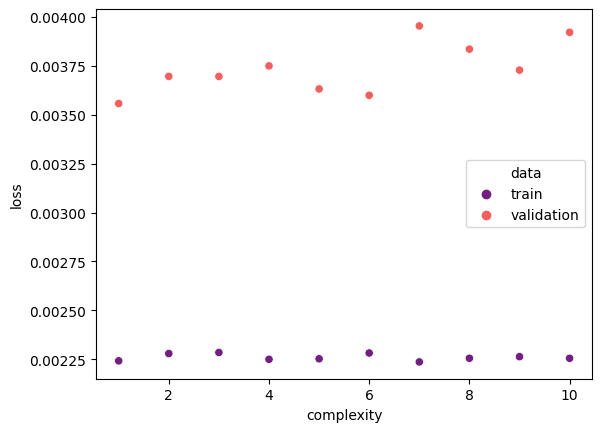

In [ ]:
validation_data_rf = {'complexity': model_complexity_list_rf + model_complexity_list_rf,
                      'loss': train_loss_list_rf + validation_loss_list_rf,
                      'mean_auc': auc_train_list_rf + auc_val_list_rf,
                      'data': ['train']*len(train_loss_list_rf) + ['validation']*len(train_loss_list_rf),
                      }

# Create a DataFrame from the validation data
validation_df_rf = pd.DataFrame(validation_data_rf)

# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_rf, x='complexity', y='loss', hue='data', palette='magma')


<Axes: xlabel='complexity', ylabel='mean_auc'>

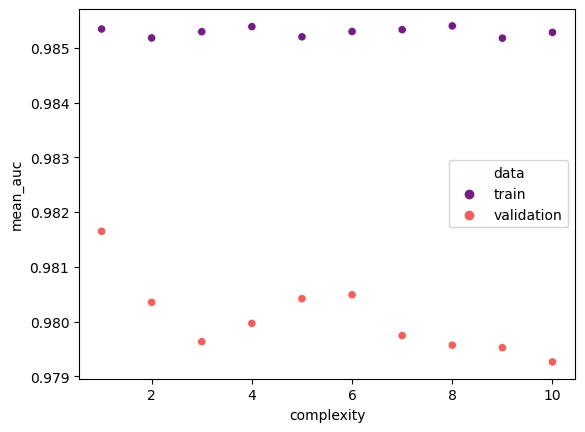

In [ ]:
# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_rf, x='complexity', y='mean_auc', hue='data', palette='magma')

In [ ]:
validation_df_rf[validation_df_rf['data']=='train']

,complexity,loss,mean_auc,data
0,1,0.002242,0.985345,train
1,2,0.002279,0.985182,train
2,3,0.002285,0.985296,train
3,4,0.002250,0.985389,train
4,5,0.002252,0.985203,train
5,6,0.002282,0.985300,train
6,7,0.002236,0.985333,train
7,8,0.002255,0.985402,train
8,9,0.002263,0.985178,train
9,10,0.002255,0.985285,train


In [ ]:
validation_df_rf[validation_df_rf['data']=='validation']

,complexity,loss,mean_auc,data
10,1,0.003558,0.981649,validation
11,2,0.003696,0.980351,validation
12,3,0.003696,0.979631,validation
13,4,0.003750,0.979966,validation
14,5,0.003632,0.980417,validation
15,6,0.003600,0.980488,validation
16,7,0.003954,0.979742,validation
17,8,0.003836,0.979568,validation
18,9,0.003728,0.979521,validation
19,10,0.003922,0.979261,validation


In [ ]:
# RF with no undersampling

# get the start time
st = time.time()

model_complexity_list_rf_nos = []
train_loss_list_rf_nos = []
validation_loss_list_rf_nos = []
auc_train_list_rf_nos = []
auc_val_list_rf_nos = []

a=0.07 #reflect actual class imbalance in dataset

count=1

for model_complexity in range(1, 11):
  print(f"Complexity {count} started")

  #X_k = np.hstack([X_train**i for i in range(1, model_complexity+1)])
  X_k = X_train
  y_k = y_train

  # Run k-fold cross-validation and compute train and validation losses
  model = RandomForestClassifier()

  train_loss, validation_loss, auc_train, auc_val = run_kfold_regression(X_k, y_k, 5, model, model_complexity, sample=False)

  model_complexity_list_rf_nos.append(model_complexity)
  train_loss_list_rf_nos.append(train_loss)
  validation_loss_list_rf_nos.append(validation_loss)
  auc_train_list_rf_nos.append(auc_train)
  auc_val_list_rf_nos.append(auc_val)

  print(f"Complexity {count} finished")
  count+=1

et = time.time()
# get the execution time
print('Execution time:', et - st, 'seconds')



2023-10-30 16:38:43.465434
Complexity 1 started
AUC :  0.985218155832096
Confusion Matrix:
[[ 5012   151]
 [   22 69351]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      5163
         1.0       1.00      1.00      1.00     69373

    accuracy                           1.00     74536
   macro avg       1.00      0.99      0.99     74536
weighted avg       1.00      1.00      1.00     74536

AUC :  0.9756147319291057
Confusion Matrix:
[[ 1231    61]
 [   27 17315]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97      1292
         1.0       1.00      1.00      1.00     17342

    accuracy                           1.00     18634
   macro avg       0.99      0.98      0.98     18634
weighted avg       1.00      1.00      1.00     18634

Fold:1
AUC :  0.9854562530056611
Confusion Matrix:
[[ 5017   149]
 [   17 69353]]

Classification Rep

In [ ]:
validation_data_rf_nos = {'complexity': model_complexity_list_rf_nos + model_complexity_list_rf_nos,
                      'loss': train_loss_list_rf_nos + validation_loss_list_rf_nos,
                      'mean_auc': auc_train_list_rf_nos + auc_val_list_rf_nos,
                      'data': ['train']*len(train_loss_list_rf_nos) + ['validation']*len(train_loss_list_rf_nos),
                      }

# Create a DataFrame from the validation data
validation_df_rf_nos = pd.DataFrame(validation_data_rf_nos)


In [ ]:
validation_df_rf_nos[validation_df_rf_nos['data']=='train']

,complexity,loss,mean_auc,data
0,1,0.002262,0.985379,train
1,2,0.002230,0.985672,train
2,3,0.002275,0.985203,train
3,4,0.002251,0.985421,train
4,5,0.002249,0.985339,train
5,6,0.002257,0.985502,train
6,7,0.002246,0.985290,train
7,8,0.002257,0.985299,train
8,9,0.002238,0.985736,train
9,10,0.002265,0.985344,train


In [ ]:
validation_df_rf_nos[validation_df_rf_nos['data']=='validation']

,complexity,loss,mean_auc,data
10,1,0.005098,0.972841,validation
11,2,0.005356,0.972526,validation
12,3,0.005034,0.972800,validation
13,4,0.005248,0.972617,validation
14,5,0.005163,0.972908,validation
15,6,0.005152,0.972706,validation
16,7,0.005163,0.972906,validation
17,8,0.005045,0.972808,validation
18,9,0.005227,0.972965,validation
19,10,0.005109,0.972814,validation


# Test on held-out test set

In [23]:
# Split the data into training and test sets (70% trainIng, 30% test)
X = df_new.drop('transplanted', axis=1)
y = df_new['transplanted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [24]:
# Impute missing data in the test set with median or mode of variables from the training set
features_with_missing_data = ['Age','Gender','Cause_of_Death_UNOS',
                              'Mechanism_of_Death','Circumstances_of_Death']

# Use SimpleImputer to compute the median/mode of features with missing data
imputer = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

for feature in features_with_missing_data:
  if feature=='Age': # if continuous replace with median
    imputer.fit(X_train[feature].to_numpy().reshape(-1, 1))
    X_train[feature] = imputer.transform(X_train[feature].to_numpy().reshape(-1, 1))
    X_test[feature] = imputer.transform(X_test[feature].to_numpy().reshape(-1, 1))

  else: # if categorical replace with mode
    imputer_cat.fit(X_train[feature].to_numpy().reshape(-1, 1))
    X_train[feature] = imputer_cat.transform(X_train[feature].to_numpy().reshape(-1, 1))
    X_test[feature] = imputer_cat.transform(X_test[feature].to_numpy().reshape(-1, 1))

y_train=y_train.to_numpy()
y_test=y_test.to_numpy()


K-Nearest Neighbors
======== Training Set ==========
AUC :  0.9672189557520338
Confusion Matrix:
[[ 6230   432]
 [   62 86446]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96      6662
         1.0       1.00      1.00      1.00     86508

    accuracy                           0.99     93170
   macro avg       0.99      0.97      0.98     93170
weighted avg       0.99      0.99      0.99     93170

======== Test Set ==========
AUC :  0.956005685975712
Confusion Matrix:
[[ 2644   252]
 [   36 36999]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95      2896
         1.0       0.99      1.00      1.00     37035

    accuracy                           0.99     39931
   macro avg       0.99      0.96      0.97     39931
weighted avg       0.99      0.99      0.99     39931



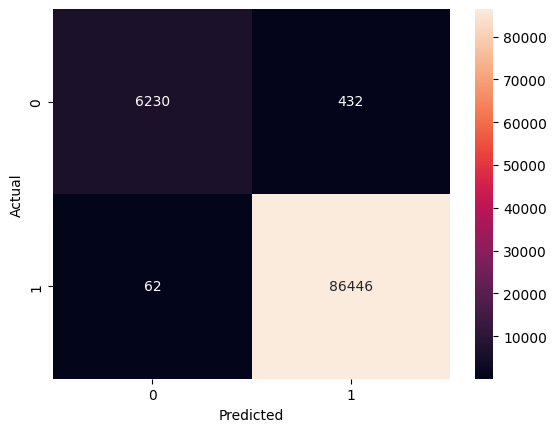

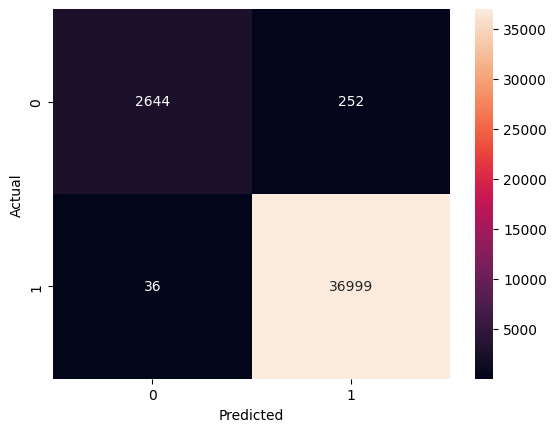

Logistic Regression CW-mod
======== Training Set ==========
AUC :  0.97250436022434
Confusion Matrix:
[[ 6291   366]
 [    1 86512]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      6657
         1.0       1.00      1.00      1.00     86513

    accuracy                           1.00     93170
   macro avg       1.00      0.97      0.98     93170
weighted avg       1.00      1.00      1.00     93170

======== Test Set ==========
AUC :  0.9710017574692442
Confusion Matrix:
[[ 2680   165]
 [    0 37086]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      2845
         1.0       1.00      1.00      1.00     37086

    accuracy                           1.00     39931
   macro avg       1.00      0.97      0.98     39931
weighted avg       1.00      1.00      1.00     39931



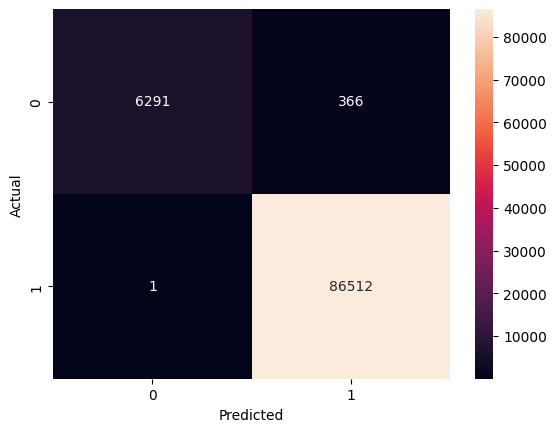

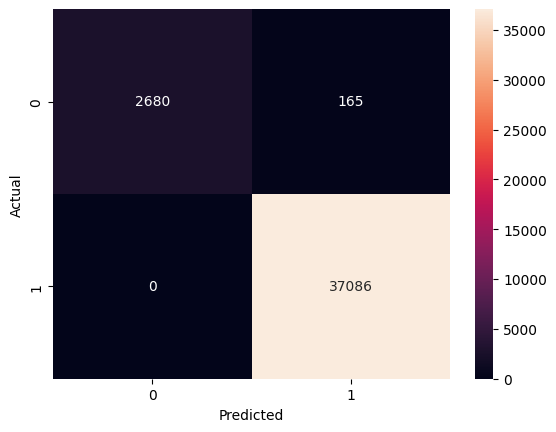

Logistic Regression CW-raw
======== Training Set ==========
AUC :  0.97250436022434
Confusion Matrix:
[[ 6291   366]
 [    1 86512]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      6657
         1.0       1.00      1.00      1.00     86513

    accuracy                           1.00     93170
   macro avg       1.00      0.97      0.98     93170
weighted avg       1.00      1.00      1.00     93170

======== Test Set ==========
AUC :  0.9710017574692442
Confusion Matrix:
[[ 2680   165]
 [    0 37086]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      2845
         1.0       1.00      1.00      1.00     37086

    accuracy                           1.00     39931
   macro avg       1.00      0.97      0.98     39931
weighted avg       1.00      1.00      1.00     39931



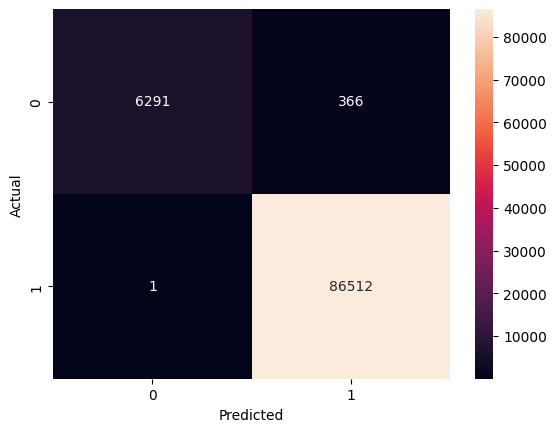

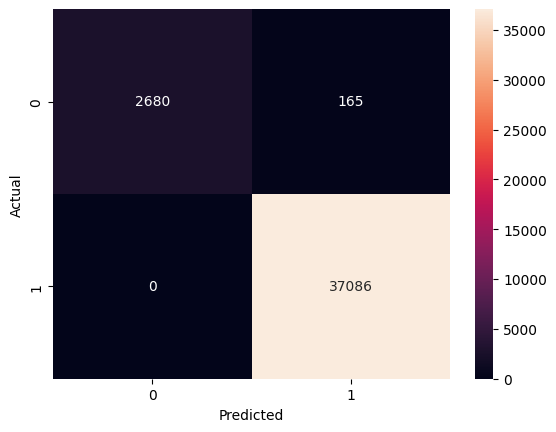

Random Forest
======== Training Set ==========
AUC :  0.9843341284145262
Confusion Matrix:
[[ 6269   201]
 [   23 86677]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      6470
         1.0       1.00      1.00      1.00     86700

    accuracy                           1.00     93170
   macro avg       1.00      0.98      0.99     93170
weighted avg       1.00      1.00      1.00     93170

======== Test Set ==========
AUC :  0.9727447855122175
Confusion Matrix:
[[ 2625   147]
 [   55 37104]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96      2772
         1.0       1.00      1.00      1.00     37159

    accuracy                           0.99     39931
   macro avg       0.99      0.97      0.98     39931
weighted avg       0.99      0.99      0.99     39931



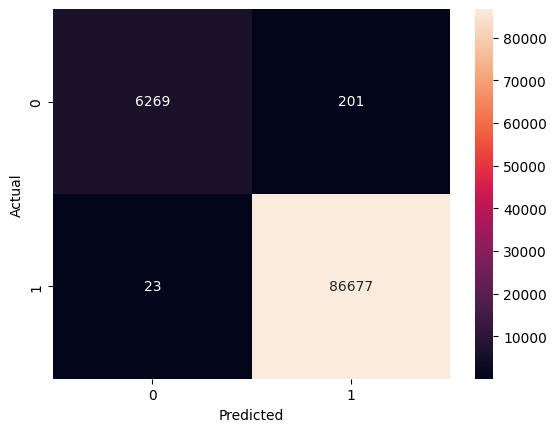

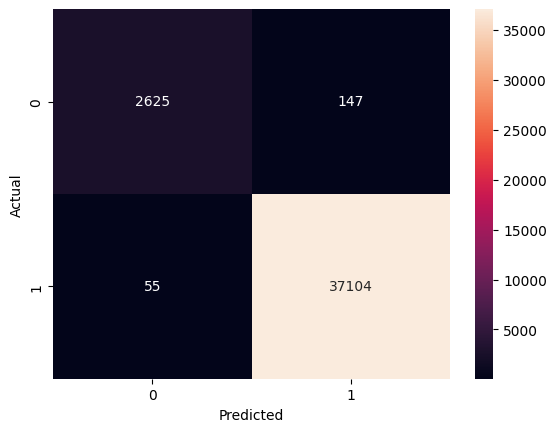

In [25]:
a=0.07
models=[
    {'label': 'K-Nearest Neighbors',
     'model': KNeighborsClassifier()},
    {'label': 'Logistic Regression CW-mod',
     'model': LogisticRegression(class_weight={0: 1-a, 1: a},penalty='l2')},
    {'label': 'Logistic Regression CW-raw',
     'model': LogisticRegression(penalty='l2')},
    {'label': 'Random Forest',
     'model': RandomForestClassifier()}
]

for pair in models:

  print(pair['label'])
  model=pair['model']
  model.fit(X_train,y_train)

  # Make predictions on the train and test sets
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  # Calculate evaluation metrics and scores for the test and training sets
  conf_matrix_test, class_report_test, auc_test = get_scores(y_pred_test, y_test)
  conf_matrix_train, class_report_train, auc_train = get_scores(y_pred_train, y_train)

  # Print scores and evaluation metrics for the training set
  print('======== Training Set ==========')
  print_scores(conf_matrix_train, class_report_train, auc_train) #, acc_train)

  # Print scores and evaluation metrics for the test set
  print('======== Test Set ==========')
  print_scores(conf_matrix_test, class_report_test, auc_test)

  # Visualizing confusion matrices for train and test
  sns.heatmap(conf_matrix_train, annot=True, fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

  sns.heatmap(conf_matrix_test, annot=True, fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

K-Nearest Neighbors
Logistic Regression CW-mod
Logistic Regression CW-raw
Random Forest


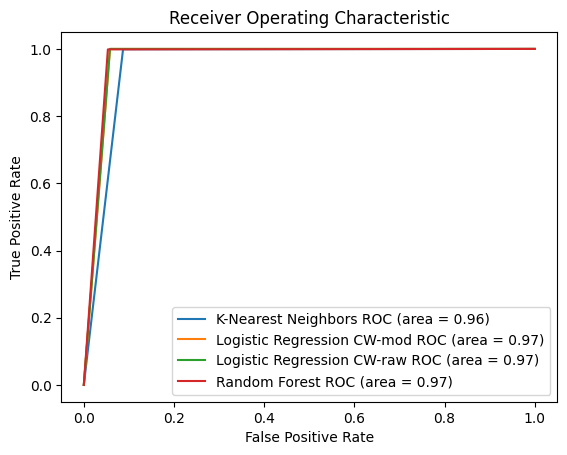

In [27]:
# Summary eval metrics for balanced set

for pair in models:

  print(pair['label'])
  model=pair['model']
  model.fit(X_train,y_train)

  # Make predictions on the train and test sets
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  # Plot the ROC curve for the training set
  fpr, tpr, thresholds = roc_curve(y_pred_test, y_test)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (pair['label'], roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display



## Part 2: Research Question 2 (Prediction of multiple transplantations)

In [28]:
df_new2.head()

,OPO,Age,Gender,Race,brain_death,Cause_of_Death_OPO,Cause_of_Death_UNOS,Mechanism_of_Death,Circumstances_of_Death,approached,...,Referral_Year,Procured_Year,outcome_heart,outcome_liver,outcome_kidney_left,outcome_kidney_right,outcome_lung_left,outcome_lung_right,outcome_intestine,outcome_pancreas
0,OPO1,62.0,M,White / Caucasian,False,NaN,Injury_External Causes,NaN,NaN,False,...,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OPO1,14.0,F,White / Caucasian,False,NaN,NaN,NaN,NaN,False,...,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OPO1,55.0,M,White / Caucasian,False,NaN,Nervous Disease,Nervous System Diseases,None of the Above,True,...,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OPO1,48.0,F,Black / African American,False,NaN,Respiratory Disease,Cardiovascular,None of the Above,False,...,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OPO1,80.0,F,White / Caucasian,False,NaN,NaN,NaN,NaN,False,...,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Get subset of transplanted donors only
print('Subset of: ' + str(df_new2[df_new2['transplanted']==True].shape[0]) + ' records') #Subset of 8972 records
df_new2=df_new2[df_new2['transplanted']==True].reset_index().drop('index',axis=1)

#Dropping this variable since it is the inclusion criterion for this Question
df_new2=df_new2.drop(['transplanted'],axis=1)

df_new2.head()

Subset of: 8972 records


,OPO,Age,Gender,Race,brain_death,Cause_of_Death_OPO,Cause_of_Death_UNOS,Mechanism_of_Death,Circumstances_of_Death,approached,...,Referral_Year,Procured_Year,outcome_heart,outcome_liver,outcome_kidney_left,outcome_kidney_right,outcome_lung_left,outcome_lung_right,outcome_intestine,outcome_pancreas
0,OPO1,25.0,M,Hispanic,True,NaN,Respiratory Disease,Injury_External Causes,Non-motor Accident,True,...,2019,2019.0,Transplanted,Transplanted,Transplanted,Transplanted,Transplanted,Transplanted,NaN,Recovered for Transplant but not Transplanted
1,OPO1,25.0,M,Black / African American,True,NaN,Injury_External Causes,Injury_External Causes,Homicide,False,...,2016,2016.0,Transplanted,Transplanted,Transplanted,Transplanted,NaN,Transplanted,NaN,Transplanted
2,OPO1,61.0,M,Hispanic,True,GSW,Other,Injury_External Causes,Suicide,True,...,2017,2017.0,NaN,Transplanted,Transplanted,Transplanted,Transplanted,Transplanted,NaN,NaN
3,OPO1,55.0,M,White / Caucasian,True,NaN,Respiratory Disease,None of the Above,None of the Above,True,...,2019,2019.0,NaN,Transplanted,Recovered for Transplant but not Transplanted,Recovered for Transplant but not Transplanted,Transplanted,Transplanted,NaN,NaN
4,OPO1,44.0,F,Black / African American,True,NaN,Respiratory Disease,Cardiovascular,None of the Above,True,...,2020,2020.0,NaN,Transplanted,Recovered for Transplant but not Transplanted,Recovered for Transplant but not Transplanted,NaN,NaN,NaN,Recovered for Research


In [30]:
df_new2.isna().sum()

OPO                          0
Age                          0
Gender                       0
Race                         0
brain_death                  0
Cause_of_Death_OPO        8052
Cause_of_Death_UNOS          0
Mechanism_of_Death           0
Circumstances_of_Death       0
approached                   0
authorized                   0
procured                     0
Tissue_Referral              0
Eye_Referral                 0
time_asystole             5985
time_brain_death          1598
time_referred                0
time_approached            120
time_authorized              6
time_procured                1
Referral_DayofWeek           0
Referral_Year                0
Procured_Year                1
outcome_heart             5334
outcome_liver             1284
outcome_kidney_left        659
outcome_kidney_right       653
outcome_lung_left         5653
outcome_lung_right        5616
outcome_intestine         8615
outcome_pancreas          7338
dtype: int64

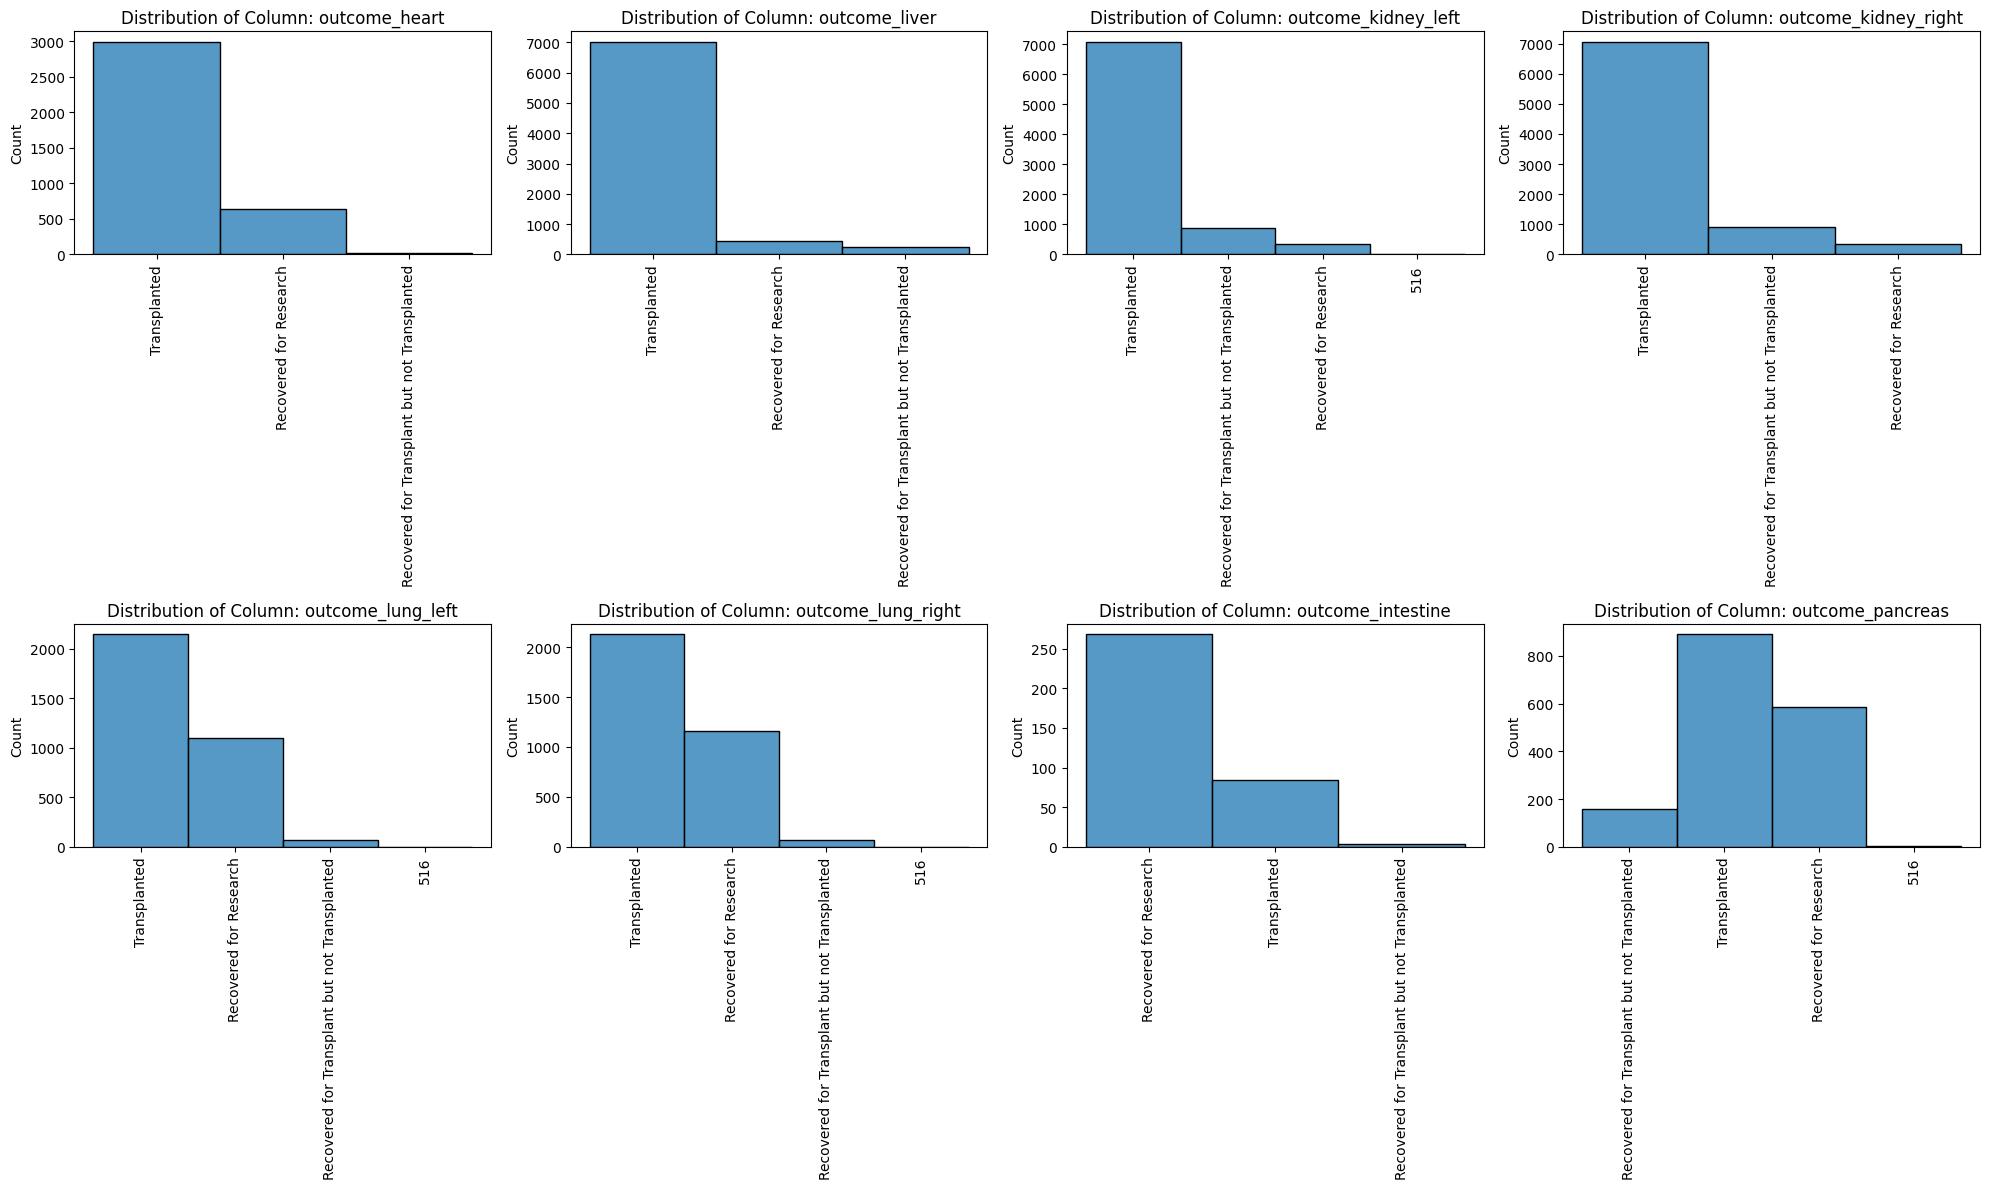

In [31]:
#Visualize data distributions

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12), sharex=False, sharey=False)
axes = axes.ravel()
cols = df_new2.columns[-8:]

for col, ax in zip(cols, axes):
    sns.histplot(data=df_new2, x=col, fill=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)

fig.tight_layout()
plt.show()

#516 value in lung left and right columns - no interpretation available, likely data entry error

In [32]:
# Replace "missing values" with new category: not recovered
outcome_vars=['outcome_heart', 'outcome_liver',
              'outcome_kidney_left', 'outcome_kidney_right',
              'outcome_lung_left', 'outcome_lung_right',
              'outcome_intestine', 'outcome_pancreas']

for col in outcome_vars:
  df_new2[col].replace({np.nan:'Not Recovered or Transplanted'},inplace=True)

In [33]:
def count_transplants(row):
  """
  Counts number of Transplanted organs in a column.

  Parameters
  ----------
  row (DataFrame): a row inside Pandas dataframe.

  Returns
  -------
  count (int): Number of transplants per row.
  """

  count=0
  for col in df.columns[-8:]:
    if row[col] == 'Transplanted':
      count+=1
  return count

count    8972.000000
mean        3.274744
std         1.663665
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         8.000000
Name: num_transplants, dtype: float64


<Axes: xlabel='num_transplants', ylabel='Count'>

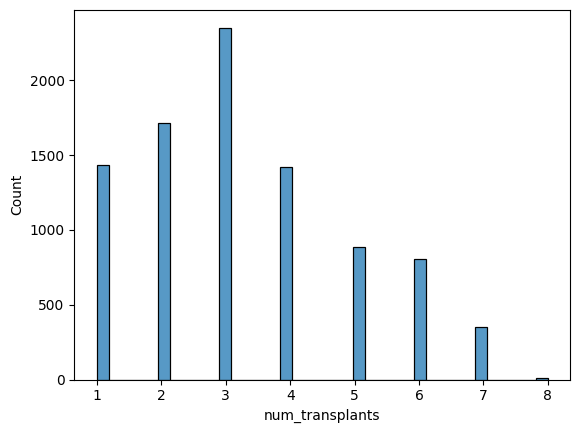

In [43]:
# New column with number of transplants
df_new2['num_transplants']=df_new2.apply(count_transplants,axis=1)

print((df_new2['num_transplants']).describe())
sns.histplot(data=df_new2, x='num_transplants', fill=True)

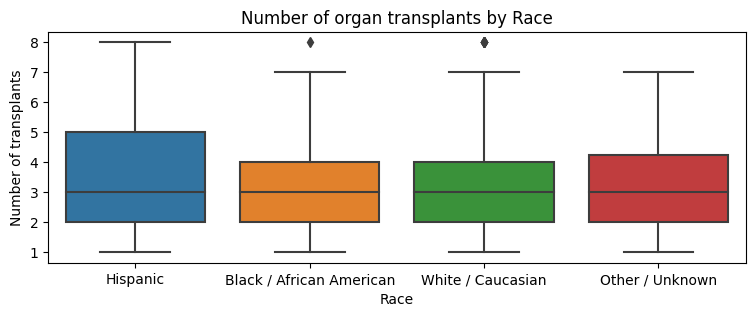

In [39]:
# Create the boxplot showing number of transplants by Race
plt.figure(figsize=(9,3))
sns.boxplot(data=df_new2, x='Race', y='num_transplants')

# Set labels and title
plt.xlabel('Race')
plt.ylabel('Number of transplants')
plt.title('Number of organ transplants by Race')

# Show the plot
plt.show()

In [44]:
df_new2['multiple_transplants']=np.where(df_new2['num_transplants']>=4,1,0) #1 = at least half of organs donated, 0 = less than half
df_new2.head()

,OPO,Age,Gender,Race,brain_death,Cause_of_Death_OPO,Cause_of_Death_UNOS,Mechanism_of_Death,Circumstances_of_Death,approached,...,outcome_heart,outcome_liver,outcome_kidney_left,outcome_kidney_right,outcome_lung_left,outcome_lung_right,outcome_intestine,outcome_pancreas,num_transplants,multiple_transplants
0,OPO1,25.0,M,Hispanic,True,NaN,Respiratory Disease,Injury_External Causes,Non-motor Accident,True,...,Transplanted,Transplanted,Transplanted,Transplanted,Transplanted,Transplanted,Not Recovered or Transplanted,Recovered for Transplant but not Transplanted,6,1
1,OPO1,25.0,M,Black / African American,True,NaN,Injury_External Causes,Injury_External Causes,Homicide,False,...,Transplanted,Transplanted,Transplanted,Transplanted,Not Recovered or Transplanted,Transplanted,Not Recovered or Transplanted,Transplanted,6,1
2,OPO1,61.0,M,Hispanic,True,GSW,Other,Injury_External Causes,Suicide,True,...,Not Recovered or Transplanted,Transplanted,Transplanted,Transplanted,Transplanted,Transplanted,Not Recovered or Transplanted,Not Recovered or Transplanted,5,1
3,OPO1,55.0,M,White / Caucasian,True,NaN,Respiratory Disease,None of the Above,None of the Above,True,...,Not Recovered or Transplanted,Transplanted,Recovered for Transplant but not Transplanted,Recovered for Transplant but not Transplanted,Transplanted,Transplanted,Not Recovered or Transplanted,Not Recovered or Transplanted,3,0
4,OPO1,44.0,F,Black / African American,True,NaN,Respiratory Disease,Cardiovascular,None of the Above,True,...,Not Recovered or Transplanted,Transplanted,Recovered for Transplant but not Transplanted,Recovered for Transplant but not Transplanted,Not Recovered or Transplanted,Not Recovered or Transplanted,Not Recovered or Transplanted,Recovered for Research,1,0


In [ ]:
print(df_new2['multiple_transplants'].value_counts())

0    5503
1    3469
Name: multiple_transplants, dtype: int64


In [50]:
# % of less than 4 transplants class
df_new2['multiple_transplants'].value_counts()[0]/len(df_new2['multiple_transplants'])

0.6133526526972805

In [51]:
# % of at least 4 transplants class
df_new2['multiple_transplants'].value_counts()[1]/len(df_new2['multiple_transplants'])

0.38664734730271955

<Axes: >

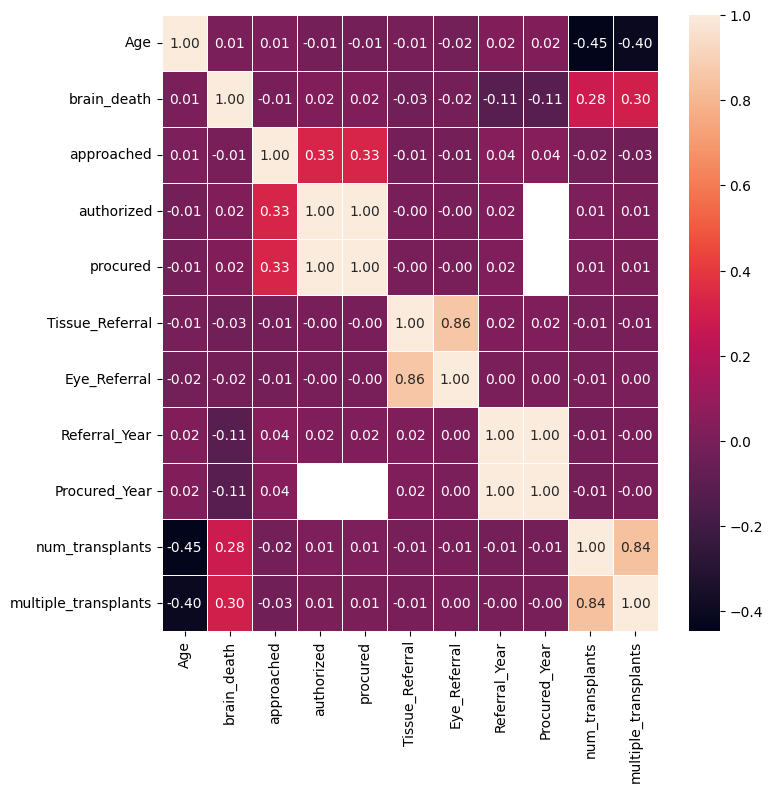

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
corr_matrix2 = df_new2.corr()
sns.heatmap(corr_matrix2, annot=True, fmt=".2f",linewidths=.5, ax=ax)

In [52]:
df_new2_v = df_new2.copy() # store copy just in case something fails

In [53]:
# Drop perfectly collinear variables
df_new2 = df_new2.drop(['Cause_of_Death_OPO','procured','Procured_Year','num_transplants', 'time_asystole', 'time_brain_death',
                        'time_referred', 'time_approached', 'time_authorized', 'time_procured'], axis=1)


In [54]:
ohe = OneHotEncoder(categories='auto',sparse=False)
df_new2['OPO'] = ohe.fit_transform(df_new2['OPO'].values.reshape(-1,1))
df_new2['Gender'] = ohe.fit_transform(df_new2['Gender'].values.reshape(-1,1))
df_new2['Race'] = ohe.fit_transform(df_new2['Race'].values.reshape(-1,1))
df_new2['brain_death'] = ohe.fit_transform(df_new2['brain_death'].values.reshape(-1,1))
#df_new2['Cause_of_Death_OPO'] = ohe.fit_transform(df_new2['Cause_of_Death_OPO'].values.reshape(-1,1))
df_new2['Cause_of_Death_UNOS'] = ohe.fit_transform(df_new2['Cause_of_Death_UNOS'].values.reshape(-1,1))
df_new2['Mechanism_of_Death'] = ohe.fit_transform(df_new2['Mechanism_of_Death'].values.reshape(-1,1))
df_new2['Circumstances_of_Death'] = ohe.fit_transform(df_new2['Circumstances_of_Death'].values.reshape(-1,1))
df_new2['Referral_DayofWeek'] = ohe.fit_transform(df_new2['Referral_DayofWeek'].values.reshape(-1,1))
df_new2['Referral_Year'] = ohe.fit_transform(df_new2['Referral_Year'].values.reshape(-1,1))
#df_new2['Procured_Year'] = ohe.fit_transform(df_new2['Procured_Year'].values.reshape(-1,1))
df_new2['approached'] = ohe.fit_transform(df_new2['approached'].values.reshape(-1,1))
df_new2['authorized'] = ohe.fit_transform(df_new2['authorized'].values.reshape(-1,1))
#df_new2['procured'] = ohe.fit_transform(df_new2['procured'].values.reshape(-1,1))

df_new2['outcome_heart'] = ohe.fit_transform(df_new2['outcome_heart'].values.reshape(-1,1))
df_new2['outcome_liver'] = ohe.fit_transform(df_new2['outcome_liver'].values.reshape(-1,1))
df_new2['outcome_kidney_left'] = ohe.fit_transform(df_new2['outcome_kidney_left'].values.reshape(-1,1))
df_new2['outcome_kidney_right'] = ohe.fit_transform(df_new2['outcome_kidney_right'].values.reshape(-1,1))
df_new2['outcome_lung_left'] = ohe.fit_transform(df_new2['outcome_lung_left'].values.reshape(-1,1))
df_new2['outcome_lung_right'] = ohe.fit_transform(df_new2['outcome_lung_right'].values.reshape(-1,1))
df_new2['outcome_intestine'] = ohe.fit_transform(df_new2['outcome_intestine'].values.reshape(-1,1))
df_new2['outcome_pancreas'] = ohe.fit_transform(df_new2['outcome_pancreas'].values.reshape(-1,1))

# CV stage - Part 2

In [55]:
# Preprocess and transform input data
X2 = df_new2.drop('multiple_transplants', axis=1).to_numpy()

# Extract the target variable
y2 = df_new2['multiple_transplants'].to_numpy()

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=1)

K-Nearest Neighbors

In [ ]:
# Loop over different model complexities

# get the start time
st = time.time()

model_complexity_list_knn2 = []
train_loss_list_knn2 = []
validation_loss_list_knn2 = []
auc_train_list_knn2 = []
auc_val_list_knn2 = []

count=1

for model_complexity in range(1, 11):
  print(f"Complexity {count} started")

  X_k = X_train2 #np.hstack([X_train**i for i in range(1, model_complexity+1)])
  y_k = y_train2

  # Run k-fold cross-validation and compute train and validation losses
  model = KNeighborsClassifier()

  train_loss, validation_loss, auc_train, auc_val = run_kfold_regression(X_k, y_k, 5, model, model_complexity, sample=False)

  model_complexity_list_knn2.append(model_complexity)
  train_loss_list_knn2.append(train_loss)
  validation_loss_list_knn2.append(validation_loss)
  auc_train_list_knn2.append(auc_train)
  auc_val_list_knn2.append(auc_val)

  print(f"Complexity {count} finished")
  count+=1

et = time.time()
# get the execution time
print('Execution time:', (et - st), 'seconds')



Complexity 1 started
AUC :  0.8751861291042592
Confusion Matrix:
[[2690  333]
 [ 259 1598]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3023
           1       0.83      0.86      0.84      1857

    accuracy                           0.88      4880
   macro avg       0.87      0.88      0.87      4880
weighted avg       0.88      0.88      0.88      4880

AUC :  0.8293660714285713
Confusion Matrix:
[[633 117]
 [ 83 365]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       750
           1       0.76      0.81      0.78       448

    accuracy                           0.83      1198
   macro avg       0.82      0.83      0.82      1198
weighted avg       0.84      0.83      0.83      1198

Fold:1
AUC :  0.8769561804278796
Confusion Matrix:
[[2698  318]
 [ 264 1613]]

Classification Report:
              precision    recall  f1

<Axes: xlabel='complexity', ylabel='loss'>

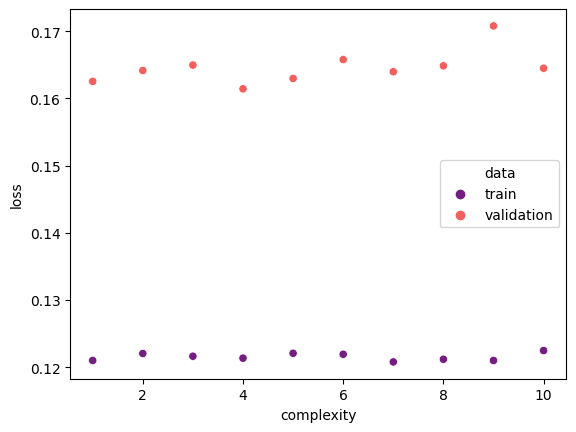

In [ ]:
# This version has an equal output from LogReg model - no pass due to ValueError!

validation_data_knn2 = {'complexity': model_complexity_list_knn2 + model_complexity_list_knn2,
                   'loss': train_loss_list_knn2 + validation_loss_list_knn2,
                   'mean_auc': auc_train_list_knn2 + auc_val_list_knn2,
                   'data': ['train']*len(train_loss_list_knn2) + ['validation']*len(train_loss_list_knn2)
                   }

# Create a DataFrame from the validation data
validation_df_knn2 = pd.DataFrame(validation_data_knn2)

# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_knn2, x='complexity', y='loss', hue='data', palette='magma')


<Axes: xlabel='complexity', ylabel='mean_auc'>

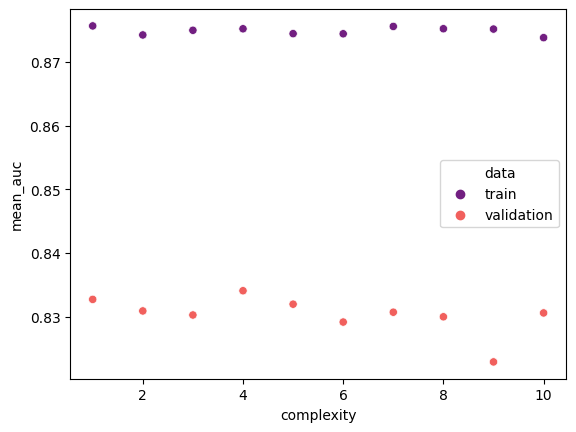

In [ ]:
# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_knn2, x='complexity', y='mean_auc', hue='data', palette='magma')


In [ ]:
validation_df_knn2[validation_df_knn2['data']=='train']

,complexity,loss,mean_auc,data
0,1,0.121015,0.875675,train
1,2,0.122055,0.874256,train
2,3,0.121648,0.874990,train
3,4,0.121363,0.875225,train
4,5,0.122089,0.874461,train
5,6,0.121941,0.874441,train
6,7,0.120801,0.875594,train
7,8,0.121198,0.875233,train
8,9,0.121014,0.875182,train
9,10,0.122496,0.873830,train


In [ ]:
validation_df_knn2[validation_df_knn2['data']=='validation']

,complexity,loss,mean_auc,data
10,1,0.162538,0.832696,validation
11,2,0.164151,0.830880,validation
12,3,0.164960,0.830244,validation
13,4,0.161428,0.834054,validation
14,5,0.162968,0.831945,validation
15,6,0.165782,0.829134,validation
16,7,0.163967,0.830682,validation
17,8,0.164850,0.829959,validation
18,9,0.170783,0.822868,validation
19,10,0.164488,0.830565,validation


Logistic regression

In [68]:
# Loop over different model complexities

# get the start time
st = time.time()

model_complexity_list_lr2 = []
train_loss_list_lr2 = []
validation_loss_list_lr2 = []
auc_train_list_lr2 = []
auc_val_list_lr2 = []


count=1

for model_complexity in range(1, 11):
  print(f"Complexity {count} started")

  X_k = X_train2
  y_k = y_train2

  # Run k-fold cross-validation and compute train and validation losses
  model = LogisticRegression(penalty='l2')

  train_loss, validation_loss, auc_train, auc_val = run_kfold_regression(X_k, y_k, 5, model, model_complexity, sample=False)

  model_complexity_list_lr2.append(model_complexity)
  train_loss_list_lr2.append(train_loss)
  validation_loss_list_lr2.append(validation_loss)
  auc_train_list_lr2.append(auc_train)
  auc_val_list_lr2.append(auc_val)

  print(f"Complexity {count} finished")
  count+=1

et = time.time()
# get the execution time
print('Execution time:', (et - st), 'seconds')


Complexity 1 started
AUC :  0.8436527194377609
Confusion Matrix:
[[2753  411]
 [ 340 1520]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3164
           1       0.79      0.82      0.80      1860

    accuracy                           0.85      5024
   macro avg       0.84      0.84      0.84      5024
weighted avg       0.85      0.85      0.85      5024

AUC :  0.8443670776032655
Confusion Matrix:
[[696 111]
 [ 78 371]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       807
           1       0.77      0.83      0.80       449

    accuracy                           0.85      1256
   macro avg       0.83      0.84      0.84      1256
weighted avg       0.85      0.85      0.85      1256

Fold:1
AUC :  0.84593822784534
Confusion Matrix:
[[2764  413]
 [ 329 1518]]

Classification Report:
              precision    recall  f1-s

<Axes: xlabel='complexity', ylabel='loss'>

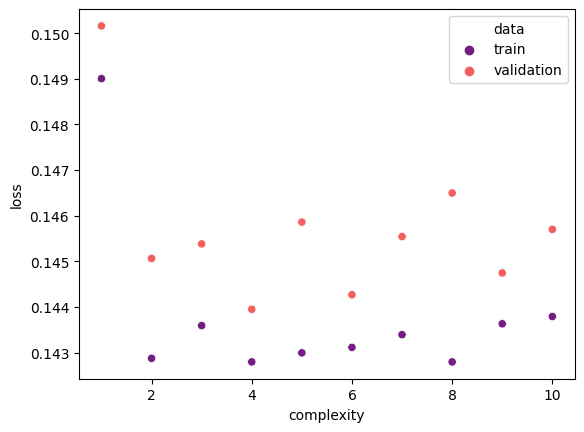

In [69]:
# This version has an equal output from LogReg model - no pass due to ValueError!

validation_data_lr2 = {'complexity': model_complexity_list_lr2 + model_complexity_list_lr2,
                   'loss': train_loss_list_lr2 + validation_loss_list_lr2,
                   'mean_auc': auc_train_list_lr2 + auc_val_list_lr2,
                   'data': ['train']*len(train_loss_list_lr2) + ['validation']*len(train_loss_list_lr2)
                   }

# Create a DataFrame from the validation data
validation_df_lr2 = pd.DataFrame(validation_data_lr2)

# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_lr2, x='complexity', y='loss', hue='data', palette='magma')

<Axes: xlabel='complexity', ylabel='mean_auc'>

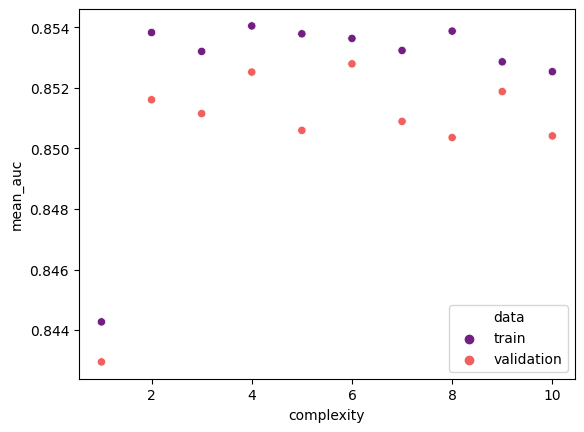

In [70]:
# Mean AUC plot
sns.scatterplot(data=validation_df_lr2, x='complexity', y='mean_auc', hue='data', palette='magma')

In [71]:
validation_df_lr2[validation_df_lr2['data']=='train']

,complexity,loss,mean_auc,data
0,1,0.149005,0.844270,train
1,2,0.142874,0.853828,train
2,3,0.143591,0.853205,train
3,4,0.142795,0.854046,train
4,5,0.142994,0.853786,train
5,6,0.143113,0.853633,train
6,7,0.143392,0.853235,train
7,8,0.142795,0.853875,train
8,9,0.143631,0.852860,train
9,10,0.143790,0.852536,train


In [72]:
validation_df_lr2[validation_df_lr2['data']=='validation']

,complexity,loss,mean_auc,data
10,1,0.150159,0.842948,validation
11,2,0.145064,0.851608,validation
12,3,0.145382,0.851151,validation
13,4,0.143949,0.852521,validation
14,5,0.145860,0.850596,validation
15,6,0.144268,0.852793,validation
16,7,0.145541,0.850893,validation
17,8,0.146497,0.850359,validation
18,9,0.144745,0.851879,validation
19,10,0.145701,0.850414,validation


In [62]:
# Loop over different model complexities

# get the start time
st = time.time()

model_complexity_list_lr2_b = []
train_loss_list_lr2_b = []
validation_loss_list_lr2_b = []
auc_train_list_lr2_b = []
auc_val_list_lr2_b = []

count=1

a=0.61 # minority class will receive more weight

for model_complexity in range(1, 11):
  print(f"Complexity {count} started")

  X_k = X_train2
  y_k = y_train2

  # Run k-fold cross-validation and compute train and validation losses
  model = LogisticRegression(class_weight={0: 1-a, 1: a},penalty='l2')

  train_loss, validation_loss, auc_train, auc_val = run_kfold_regression(X_k, y_k, 5, model, model_complexity, sample=True)

  model_complexity_list_lr2_b.append(model_complexity)
  train_loss_list_lr2_b.append(train_loss)
  validation_loss_list_lr2_b.append(validation_loss)
  auc_train_list_lr2_b.append(auc_train)
  auc_val_list_lr2_b.append(auc_val)

  print(f"Complexity {count} finished")
  count+=1

et = time.time()
# get the execution time
print('Execution time:', (et - st), 'seconds')



Complexity 1 started
AUC :  0.8352386852575061
Confusion Matrix:
[[2517  345]
 [ 419 1586]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2862
           1       0.82      0.79      0.81      2005

    accuracy                           0.84      4867
   macro avg       0.84      0.84      0.84      4867
weighted avg       0.84      0.84      0.84      4867

AUC :  0.8362857142857143
Confusion Matrix:
[[615  85]
 [103 397]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       700
           1       0.82      0.79      0.81       500

    accuracy                           0.84      1200
   macro avg       0.84      0.84      0.84      1200
weighted avg       0.84      0.84      0.84      1200

Fold:1
AUC :  0.8384662874689242
Confusion Matrix:
[[2546  337]
 [ 414 1594]]

Classification Report:
              precision    recall  f1

<Axes: xlabel='complexity', ylabel='loss'>

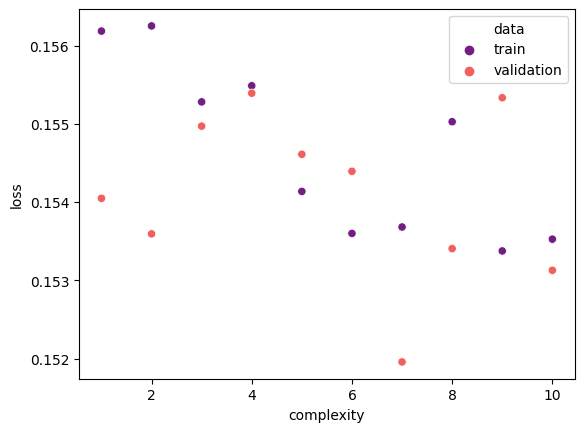

In [63]:
# This version has an equal output from LogReg model - no pass due to ValueError!

validation_data_lr2_b = {'complexity': model_complexity_list_lr2_b + model_complexity_list_lr2_b,
                   'loss': train_loss_list_lr2_b + validation_loss_list_lr2_b,
                   'mean_auc': auc_train_list_lr2_b + auc_val_list_lr2_b,
                   'data': ['train']*len(train_loss_list_lr2_b) + ['validation']*len(train_loss_list_lr2_b)
                   }

# Create a DataFrame from the validation data
validation_df_lr2_b = pd.DataFrame(validation_data_lr2_b)

# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_lr2_b, x='complexity', y='loss', hue='data', palette='magma')


<Axes: xlabel='complexity', ylabel='mean_auc'>

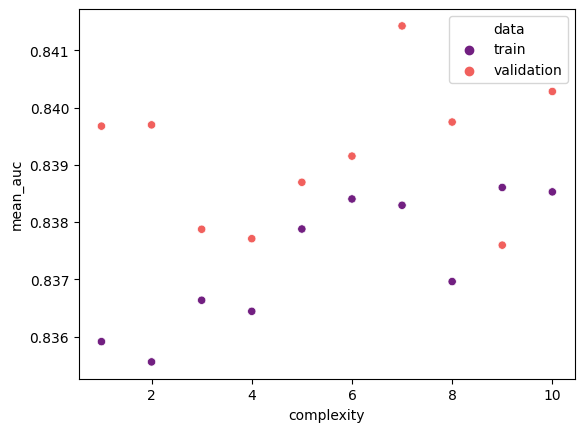

In [64]:
# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_lr2_b, x='complexity', y='mean_auc', hue='data', palette='magma')

In [65]:
validation_df_lr2_b[validation_df_lr2_b['data']=='train']

,complexity,loss,mean_auc,data
0,1,0.156185,0.835911,train
1,2,0.156251,0.835557,train
2,3,0.155280,0.836634,train
3,4,0.155487,0.836440,train
4,5,0.154137,0.837878,train
5,6,0.153600,0.838403,train
6,7,0.153682,0.838293,train
7,8,0.155027,0.836960,train
8,9,0.153376,0.838604,train
9,10,0.153527,0.838527,train


In [66]:
validation_df_lr2_b[validation_df_lr2_b['data']=='validation']

,complexity,loss,mean_auc,data
10,1,0.154048,0.839675,validation
11,2,0.153594,0.839697,validation
12,3,0.154971,0.837874,validation
13,4,0.155392,0.837709,validation
14,5,0.154611,0.838694,validation
15,6,0.154393,0.839152,validation
16,7,0.151958,0.841426,validation
17,8,0.153406,0.839747,validation
18,9,0.155333,0.837597,validation
19,10,0.153129,0.840280,validation


Random forest

In [ ]:
# Loop over different model complexities

# get the start time
st = time.time()

model_complexity_list_rf2 = []
train_loss_list_rf2 = []
validation_loss_list_rf2 = []
auc_train_list_rf2 = []
auc_val_list_rf2 = []

a=0.07 #reflect actual class imbalance in dataset

count=1

for model_complexity in range(1, 11):
  print(f"Complexity {count} started")

  #X_k = np.hstack([X_train**i for i in range(1, model_complexity+1)])
  X_k = X_train2
  y_k = y_train2

  # Run k-fold cross-validation and compute train and validation losses
  model = RandomForestClassifier()

  train_loss, validation_loss, auc_train, auc_val = run_kfold_regression(X_k, y_k, 5, model, model_complexity, sample=False)

  model_complexity_list_rf2.append(model_complexity)
  train_loss_list_rf2.append(train_loss)
  validation_loss_list_rf2.append(validation_loss)
  auc_train_list_rf2.append(auc_train)
  auc_val_list_rf2.append(auc_val)

  print(f"Complexity {count} finished")
  count+=1

et = time.time()
# get the execution time
print('Execution time:', et - st, 'seconds')


2023-10-29 22:33:27.892401
Complexity 1 started
AUC :  0.9374687616097543
Confusion Matrix:
[[2830  169]
 [ 130 1762]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2999
           1       0.91      0.93      0.92      1892

    accuracy                           0.94      4891
   macro avg       0.93      0.94      0.94      4891
weighted avg       0.94      0.94      0.94      4891

AUC :  0.819673736888034
Confusion Matrix:
[[618 116]
 [ 93 366]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       734
           1       0.76      0.80      0.78       459

    accuracy                           0.82      1193
   macro avg       0.81      0.82      0.82      1193
weighted avg       0.83      0.82      0.83      1193

Fold:1
AUC :  0.9362973324999612
Confusion Matrix:
[[2789  157]
 [ 142 1774]]

Classification Report:
           

<Axes: xlabel='complexity', ylabel='loss'>

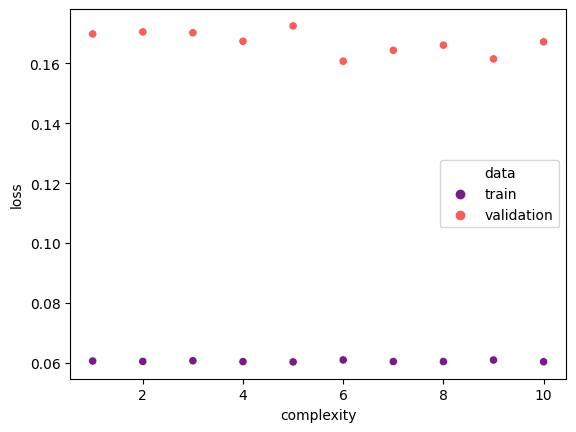

In [ ]:
validation_data_rf2 = {'complexity': model_complexity_list_rf2 + model_complexity_list_rf2,
                      'loss': train_loss_list_rf2 + validation_loss_list_rf2,
                      'mean_auc': auc_train_list_rf2 + auc_val_list_rf2,
                      'data': ['train']*len(train_loss_list_rf2) + ['validation']*len(train_loss_list_rf2),
                      }

# Create a DataFrame from the validation data
validation_df_rf2 = pd.DataFrame(validation_data_rf2)

# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df_rf2, x='complexity', y='loss', hue='data', palette='magma')



<Axes: xlabel='complexity', ylabel='mean_auc'>

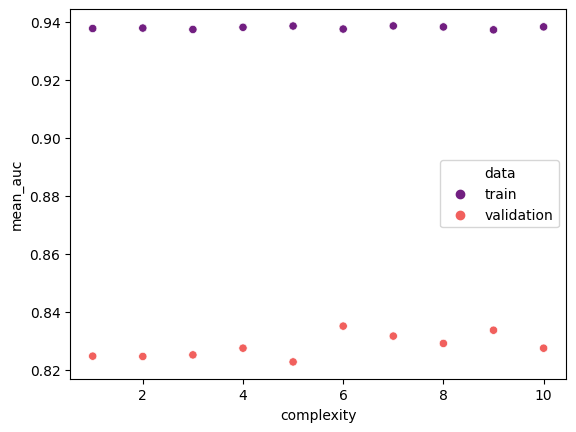

In [ ]:
sns.scatterplot(data=validation_df_rf2, x='complexity', y='mean_auc', hue='data', palette='magma')


In [ ]:
validation_df_rf2[validation_df_rf2['data']=='train']

,complexity,loss,mean_auc,data
0,1,0.060661,0.937619,train
1,2,0.060526,0.937772,train
2,3,0.060750,0.937294,train
3,4,0.060450,0.938032,train
4,5,0.060364,0.938476,train
5,6,0.061022,0.937436,train
6,7,0.060492,0.938509,train
7,8,0.060483,0.938157,train
8,9,0.060995,0.937160,train
9,10,0.060422,0.938180,train


In [ ]:
validation_df_rf2[validation_df_rf2['data']=='validation']

,complexity,loss,mean_auc,data
10,1,0.169773,0.824780,validation
11,2,0.170458,0.824672,validation
12,3,0.170176,0.825216,validation
13,4,0.167329,0.827533,validation
14,5,0.172450,0.822791,validation
15,6,0.160687,0.835128,validation
16,7,0.164331,0.831690,validation
17,8,0.166049,0.829159,validation
18,9,0.161458,0.833713,validation
19,10,0.167140,0.827523,validation


# Test on held-out test set

KNeighborsClassifier()
======== Training Set ==========
AUC :  0.850837023010813
Confusion Matrix:
[[3398  413]
 [ 469 2000]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      3811
           1       0.83      0.81      0.82      2469

    accuracy                           0.86      6280
   macro avg       0.85      0.85      0.85      6280
weighted avg       0.86      0.86      0.86      6280

======== Test Set ==========
AUC :  0.8137373052204618
Confusion Matrix:
[[1384  225]
 [ 252  831]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1609
           1       0.79      0.77      0.78      1083

    accuracy                           0.82      2692
   macro avg       0.82      0.81      0.82      2692
weighted avg       0.82      0.82      0.82      2692



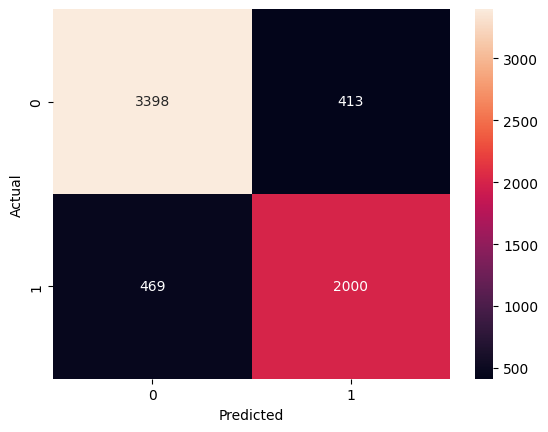

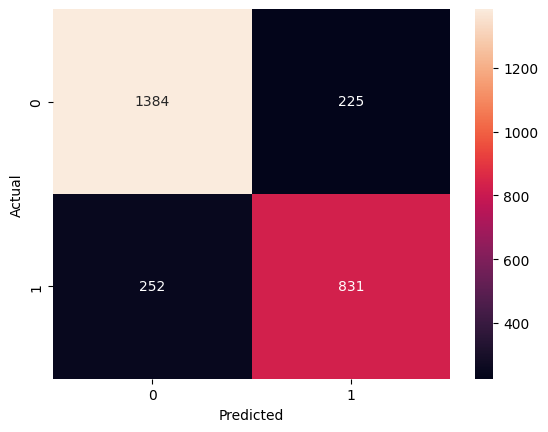

LogisticRegression(class_weight={0: 0.39, 1: 0.61})
======== Training Set ==========
AUC :  0.8245844838058894
Confusion Matrix:
[[3281  451]
 [ 586 1962]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      3732
           1       0.81      0.77      0.79      2548

    accuracy                           0.83      6280
   macro avg       0.83      0.82      0.83      6280
weighted avg       0.83      0.83      0.83      6280

======== Test Set ==========
AUC :  0.8359209928474066
Confusion Matrix:
[[1406  189]
 [ 230  867]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1595
           1       0.82      0.79      0.81      1097

    accuracy                           0.84      2692
   macro avg       0.84      0.84      0.84      2692
weighted avg       0.84      0.84      0.84      2692



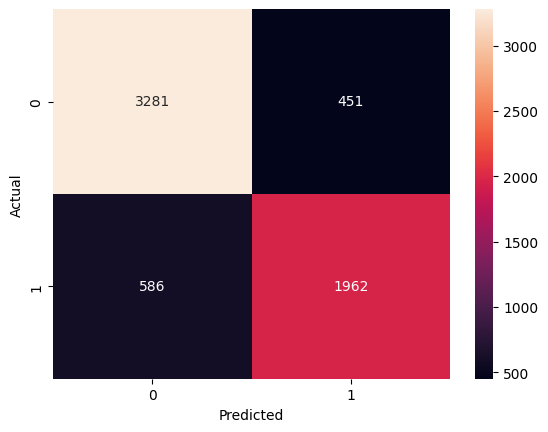

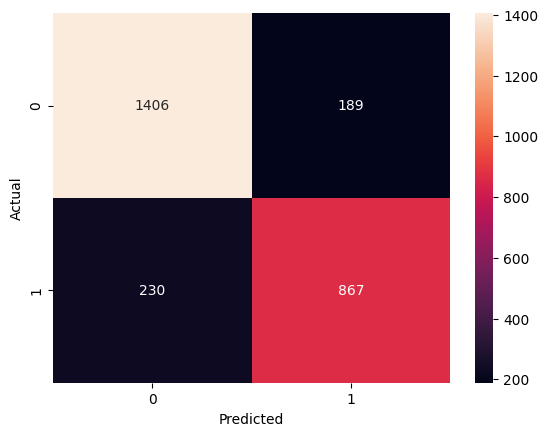

LogisticRegression()
======== Training Set ==========
AUC :  0.842360818631181
Confusion Matrix:
[[3441  521]
 [ 426 1892]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3962
           1       0.78      0.82      0.80      2318

    accuracy                           0.85      6280
   macro avg       0.84      0.84      0.84      6280
weighted avg       0.85      0.85      0.85      6280

======== Test Set ==========
AUC :  0.8506016548463355
Confusion Matrix:
[[1469  223]
 [ 167  833]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1692
           1       0.79      0.83      0.81      1000

    accuracy                           0.86      2692
   macro avg       0.84      0.85      0.85      2692
weighted avg       0.86      0.86      0.86      2692



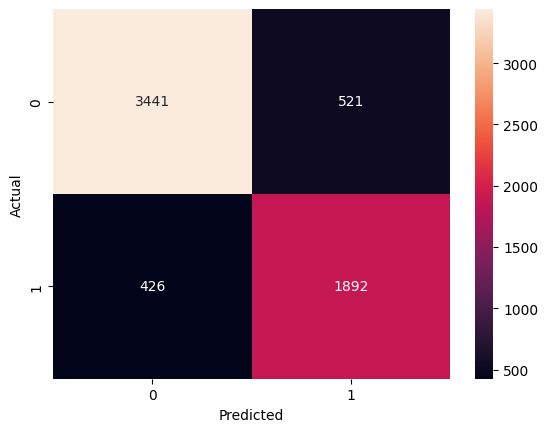

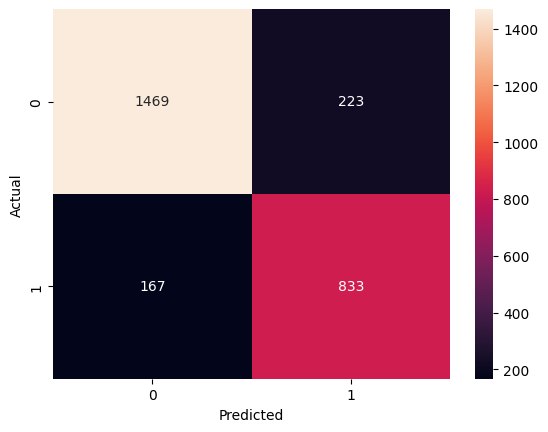

RandomForestClassifier()
======== Training Set ==========
AUC :  0.9335031847133758
Confusion Matrix:
[[3693  232]
 [ 174 2181]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3925
           1       0.90      0.93      0.91      2355

    accuracy                           0.94      6280
   macro avg       0.93      0.93      0.93      6280
weighted avg       0.94      0.94      0.94      6280

======== Test Set ==========
AUC :  0.8242568118201467
Confusion Matrix:
[[1435  255]
 [ 201  801]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1690
           1       0.76      0.80      0.78      1002

    accuracy                           0.83      2692
   macro avg       0.82      0.82      0.82      2692
weighted avg       0.83      0.83      0.83      2692



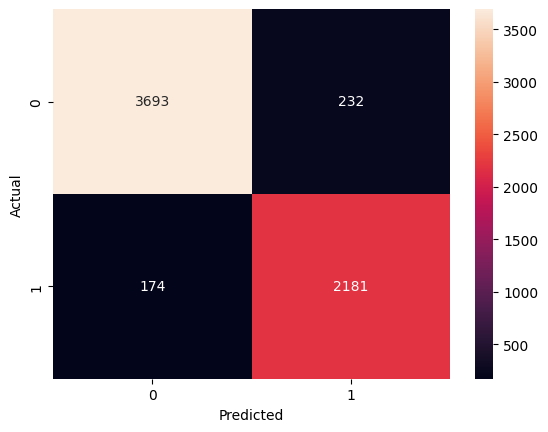

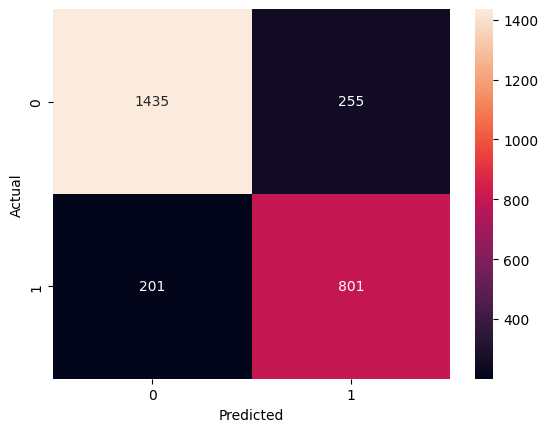

In [74]:
# Summary metrics - confusion matrices and class reports

a=0.61
models2=[
    {'label': 'K-Nearest Neighbors',
     'model': KNeighborsClassifier()},
    {'label': 'Logistic Regression',
     'model': LogisticRegression(class_weight={0: 1-a, 1: a},penalty='l2')},
    {'label': 'Logistic Regression',
     'model': LogisticRegression(penalty='l2')},
    {'label': 'Random Forest',
     'model': RandomForestClassifier()}
]


for pair in models2:

  print(pair['model'])
  model=pair['model']
  model.fit(X_train2,y_train2)

  # Make predictions on the train and test sets
  y_pred_train = model.predict(X_train2)
  y_pred_test = model.predict(X_test2)

  # Calculate evaluation metrics and scores for the test and training sets
  conf_matrix_test, class_report_test, auc_test = get_scores(y_pred_test, y_test2)
  conf_matrix_train, class_report_train, auc_train = get_scores(y_pred_train, y_train2)

  # Print scores and evaluation metrics for the training set
  print('======== Training Set ==========')
  print_scores(conf_matrix_train, class_report_train, auc_train) #, acc_train)

  # Print scores and evaluation metrics for the test set
  print('======== Test Set ==========')
  print_scores(conf_matrix_test, class_report_test, auc_test)

  # Visualizing confusion matrices for train and test
  sns.heatmap(conf_matrix_train, annot=True, fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

  sns.heatmap(conf_matrix_test, annot=True, fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()



KNeighborsClassifier()
LogisticRegression(class_weight={0: 0.39, 1: 0.61})
LogisticRegression()
RandomForestClassifier()


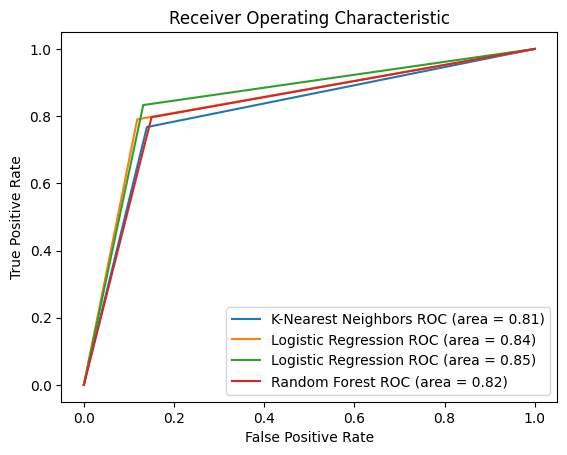

In [75]:
# Summary AUROC metrics

for pair in models2:

  print(pair['model'])
  model=pair['model']
  model.fit(X_train2,y_train2)

  # Make predictions on the train and test sets
  y_pred_train = model.predict(X_train2)
  y_pred_test = model.predict(X_test2)

  # Plot the ROC curve for the training set
  fpr, tpr, thresholds = roc_curve(y_pred_test, y_test2)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (pair['label'], roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display